# Set Up

### Imports

In [1]:
import os, pickle, random, itertools
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import time
import mne
import scipy.stats as stats
from scipy.signal import resample,resample_poly,decimate,periodogram,welch,lfilter,filtfilt
# Sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Tensorflow
import tensorflow as tf

LABEL_NAMES = [ "Inactivity",
                "Double Blink", "Look Left", "Look Right", "Look Down", "Look Up",
                "Rotate Head Left", "Rotate Head Right",
                "Unknown"]

Platform: _Windows 10_ <br>
Python: _3.10.11_ <br>
pandas: _v.2.0.2_ <br>
matplotlib: _v.3.7.1_ <br>
numpy: _v.1.24.3_ <br>
scipy: _v.1.10.1_ <br>
mne: _v.1.4.0_ <br>
sklearn: _v.1.2.2_ <br>
tensorflow: _v.2.10.0_

### Custom Plot Functions

#### Documentation:

- __get_dataframes_by_label()__: _Returns a list of all the dataframes (movements - fragments) of a specific category._<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-fragments (_list_): A list containing all the movements fragments.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-fragments_id (_list_): A list containing the labels for each movement in the fragments list.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-selected_label (_int_): The Label (Class ID) you want to use.<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(_list_): All the dataframes of the Class ID you choose.<br>
&nbsp;&nbsp;&nbsp;Example Usage: <span style="color:green"> double_blink_dataframes = get_dataframes_by_label(fragments, fragments_id, 1)<br> <span>

- __plot_signals_comparison()__: _Plot a comparison of multiple signals in both time domain and frequency domain (using PSD)._<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-signals (_list of numpy arrays_): A list of signals to be plotted.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-names (_list of str_): A list of names corresponding to each signal.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-fs (_int_): The sampling rate of the signals.<br>
&nbsp;&nbsp;&nbsp;Raises:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_ValueError_: If the number of signals does not match the number of names.<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_None_<br>

- __plot_history_metrics()__:  _Visualize a model training history, by plotting the metrics present in  keras.callbacks.History_<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-history (_history object(`tf.keras.callbacks.History`)_): Containing metrics used in the training process. For example: ['accuracy', 'loss'. . .]<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-val_split (_bool_): If validation split is used and you want to plot it set to _`True`_ (_Default:`False`_).<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-metrics_to_plot (_list_): Select the metrics you want to plot. If _`None`_ all the metrics present in the history will be displayed.(_Default:`None`_)<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;None (displays the plot)<br>

- __plot_mean_histories()__: _Plot mean training and validation accuracy, loss, and their standard deviations for each epoch._<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-histories ( _list of history objects (`tf.keras.callbacks.History`)_ ): List of dictionaries containing training and validation history data.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Each dictionary should have keys: 'accuracy', 'val_accuracy', 'loss', 'val_loss', where each key maps to a list of metric values at each epoch.<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;None (displays the plot)<br>

- __plot_Confusion_Matrix()__: _Calculates the confusion matrix based on true and predicted labels and plots it as a heatmap. It also provides information on the number of correct predictions._<br>
&nbsp;&nbsp;&nbsp;Parameters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-true_labels (_list or array_): True class labels for the dataset.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-prediction_labels (_list or array_): Predicted class labels from the model.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-classes (_list_): List of class names in the order they appear in the confusion matrix.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-title (_str, optional_): Title for the confusion matrix plot (_Default: 'Confusion matrix'_).<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- cmap (_matplotlib colormap, optional_): Colormap for the matrix colors (_Default: plt.cm.Blues_).<br>
&nbsp;&nbsp;&nbsp;Returns:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;None (displays the plot)<br>



In [3]:
def get_dataframes_by_label(fragments, fragments_id, selected_label):
    return [fragments[i] for i, label in enumerate(fragments_id) if label == selected_label]

def plot_signals_comparison(signals, names, fs):
    if len(signals) != len(names): raise ValueError("Number of signals must match the number of names.")

    plt.figure(figsize=(12, 8))
    plt.style.use("ggplot")

    # Plot in time domain (first subplot)
    plt.subplot(2, 1, 1)
    for i, signal in enumerate(signals):
        plt.plot(signal, label=names[i])
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title('Signal Comparison')
    plt.legend()
    plt.grid(True)

    # Plot in frequency domain (second subplot)
    plt.subplot(2, 1, 2)
    for i, signal in enumerate(signals):
        freq, psd = plt.psd(signal, NFFT=len(signal), Fs=fs, label=names[i])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title('Power Spectral Density of Signals')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_movement(dataframe, channels, fs=256, save_dir = None, filename = None):
    plt.style.use('default')
    #channels = ['AF7', 'AF8', 'TP9', 'TP10', 'X', 'Y', 'Z']
    time = np.linspace(0, len(dataframe) / fs, len(dataframe))

    fig, axs = plt.subplots(4, 2, figsize=(20, 15))
    axs = axs.ravel()  # Flatten the 2D array of axes

    for i, channel in enumerate(channels):
        # Determine color based on channel type
        color = 'blue' if channel in ['AF7', 'AF8', 'TP9', 'TP10'] else 'black'

        axs[i].plot(time, dataframe[channel], label=channel, color=color)
        axs[i].set_title(channel)
        axs[i].set_xlabel("Time (s)")
        axs[i].grid(True, color='black', linestyle=':')  # Apply grid

        # Set y-axis limits
        if channel in ['AF7', 'AF8']:
            axs[i].set_ylim([-150, 150])  # Adjust EEG limits as needed
        elif channel in ['TP9', 'TP10']:
            axs[i].set_ylim([-400, 400])  # Adjust EEG limits as needed
        else:
            axs[i].set_ylim([-150, 150])  # Adjust gyro limits as needed
        axs[i].legend()

    # For the last subplot, compute and plot the PSD using Welch's method
    for channel in channels:
        freqs, Pxx = plt.psd(dataframe[channel], NFFT=len(dataframe[channel]), Fs=fs,label=channel)

    axs[-1].set_title("Power Spectral Density (PSD)")
    axs[-1].set_xlabel("Frequency (Hz)")
    axs[-1].set_ylabel("Power/Frequency (dB/Hz)")
    axs[-1].set_xlim([0, fs/2])
    #axs[-1].set_ylim([-60, 60])
    axs[-1].grid(True)
    axs[-1].legend(loc='lower right')
    axs[-1].set_facecolor("azure")

    # Saving plot
    if(save_dir and filename):
        plt.ioff()
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
        plt.close()
    # Show plot
    else:
        plt.ioff()
        plt.tight_layout()
        plt.show()
        
def plot_cv_class_distribution_per_fold(cv_model,data,labels):
    class_distributions = [] # Initialize an array to store class distributions for each fold
    plt.figure(figsize=(15, 6)) # Create a figure and axis

    for fold, (train_idx, val_idx) in enumerate(cv_model.split(data, labels)):
        labels = np.array(labels, dtype=int)
        class_counts = np.bincount(labels[val_idx], minlength=9)  # Count the occurrences of each class in the validation fold
        class_distributions.append(class_counts)

        # Plot the class distribution for the current fold
        bars = plt.bar(np.arange(9) + fold * 0.1, class_counts, width=0.1, align='center', label=f'Fold {fold + 1}')

        # Annotate bars with class distribution numbers
        for bar, count in zip(bars, class_counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

    # Set labels and title
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in StratifiedKFold Folds')
    plt.xticks(np.arange(9), labels=np.arange(9))
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_holdout_split(X_train, X_test, y_train, y_test):
    # Calculate the class distribution in the training and testing sets
    train_class_counts = {class_label: y_train.count(class_label) for class_label in set(y_train)}
    test_class_counts = {class_label: y_test.count(class_label) for class_label in set(y_train)}
    class_labels = sorted(list(set(y_train))) # Get the class labels and sort them for consistent ordering in the plot

    # Get the counts for each class label
    train_counts = [train_class_counts[label] for label in class_labels]
    test_counts = [test_class_counts[label] for label in class_labels]

    # Set up the positions for the bars
    x = np.arange(len(class_labels))

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.4/2, train_counts, width=0.4, label='Training')
    plt.bar(x + 0.4/2, test_counts, width=0.4, label='Testing')

    # Add count numbers above each bar
    for i, count in enumerate(train_counts):
        plt.text(x[i] - 0.4/2, count + 10, str(count), ha='center', va='bottom')
    for i, count in enumerate(test_counts):
        plt.text(x[i] + 0.4/2, count + 10, str(count), ha='center', va='bottom')

    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Data Split Per Class')
    plt.xticks(x, class_labels)
    plt.legend()
    plt.show()

def plot_history_metrics(history: tf.keras.callbacks.History, val_split=False, metrics_to_plot=None):
    plt.style.use("ggplot")

    if metrics_to_plot is None:
        # if no specific metrics are provided, plot all metrics
        metrics_to_plot = list(history.history.keys())

    if(val_split):
        total_plots = len(metrics_to_plot)//2
    else:
        total_plots = len(metrics_to_plot)

    cols = total_plots // 2
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))

    if(val_split):
        for i in range(0, len(metrics_to_plot)//2):
            key = metrics_to_plot[i]
            key_val = metrics_to_plot[i + len(metrics_to_plot)//2]
            value = history.history[key]
            val_value = history.history[key_val]
            plt.subplot(rows, cols, pos[i])
            plt.plot(range(len(value)), value, label = key)
            plt.plot(range(len(val_value)), val_value, label = key_val)
            plt.title(str(key))
            plt.legend()
    else:
        for i, key in enumerate(metrics_to_plot):
            value = history.history[key]
            plt.subplot(rows, cols, pos[i])
            plt.plot(range(len(value)), value)
            plt.title(str(key))
    plt.show()

def plot_mean_histories(histories):
    fig, axs = plt.subplots(2, figsize=(15, 10))
    plt.style.use("ggplot")

    # Initialize lists to store mean and std values
    mean_accuracy,std_accuracy,mean_val_accuracy,std_val_accuracy = [],[],[],[]
    mean_loss,std_loss,mean_val_loss,std_val_loss = [],[],[],[]

    # Collect metric values from histories
    for epoch in range(len(histories[0]['accuracy'])):
        accuracy_values = [history['accuracy'][epoch] for history in histories]
        val_accuracy_values = [history['val_accuracy'][epoch] for history in histories]
        loss_values = [history['loss'][epoch] for history in histories]
        val_loss_values = [history['val_loss'][epoch] for history in histories]

        mean_accuracy.append(np.mean(accuracy_values))
        std_accuracy.append(np.std(accuracy_values))
        mean_val_accuracy.append(np.mean(val_accuracy_values))
        std_val_accuracy.append(np.std(val_accuracy_values))
        mean_loss.append(np.mean(loss_values))
        std_loss.append(np.std(loss_values))
        mean_val_loss.append(np.mean(val_loss_values))
        std_val_loss.append(np.std(val_loss_values))

    # Plot training and validation accuracy
    axs[0].plot(mean_accuracy, color='blue', label='Train Accuracy')
    axs[0].plot(mean_val_accuracy, color='orange', linestyle='--', label='Val Accuracy')

    # Add transparency based on standard deviation
    axs[0].fill_between(range(len(histories[0]['accuracy'])), np.subtract(mean_accuracy, std_accuracy),
                        np.add(mean_accuracy, std_accuracy), color='blue', alpha=0.2)
    axs[0].fill_between(range(len(histories[0]['accuracy'])), np.subtract(mean_val_accuracy, std_val_accuracy),
                        np.add(mean_val_accuracy, std_val_accuracy), color='red', alpha=0.2)
    axs[0].set_ylim(0, 1) # Set y-axis limits for accuracy from 0 to 1

    # Plot training and validation loss
    axs[1].plot(mean_loss, color='blue', label='Train Loss')
    axs[1].plot(mean_val_loss, color='red', linestyle='--', label='Val Loss')

    # Add transparency based on standard deviation
    axs[1].fill_between(range(len(histories[0]['loss'])), np.subtract(mean_loss, std_loss),
                        np.add(mean_loss, std_loss), color='blue', alpha=0.2)
    axs[1].fill_between(range(len(histories[0]['loss'])), np.subtract(mean_val_loss, std_val_loss),
                        np.add(mean_val_loss, std_val_loss), color='red', alpha=0.2)
    axs[1].set_ylim(0, None) #Set y-axis lower limit for loss to 0

    # Set common labels and titles
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)  # Legend on the right side
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    plt.tight_layout()
    plt.show()
    
def plot_Confusion_Matrix(true_labels, prediction_labels, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    if (len(true_labels)==len(prediction_labels)):
        cm = confusion_matrix(y_true=true_labels,y_pred=prediction_labels)
        counter = 0
        for i in range(len(true_labels)):
            if(true_labels[i]==prediction_labels[i]): counter +=1
        print("\nCorrect predictions: " + str(counter)+"/"+str(len(true_labels)))
        plt.figure(figsize=(12, 8))
        plt.style.use("ggplot")
        plt.grid(False)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else: print("true_labels lenght != prediction_labels lenght")

__________________________________________________________________________________________________________________________________

# Signal Segmentation

In this step, we use the __segmentation.py__ script to manually create epochs(segments) from the Raw EEG & Gyroscope sessions.<br>
Each segment represents a specific movement and it is saved as a DataFrame with a label in a pickle file (.pkl).<br>
Each .pkl file then stored in a folder (__MY_DATA/Labeled_Fragments__). Here we use a __3sec__ window for each segment.<br>
So, each __.pkl__ file contains __fragments__ (dataframes) and __fragments_id__ (the label for each dataframe).<br>

To create epochs (manually) run the __segmentation.py__ script in the __tools__ folder : <span style="color:blue">*python .\segmentation.py* <br></span>
<span style="color:blue">
*Enter a file path:_ ...\RAW_MUSE_DATA\Sessions_EEG_GS\user_1\double_tap\ID78\EEG2_GYRO2.csv*<br>
*Enter filename: name_of_pkl_file*
</span>

__________________________________________________________________________________________________________________________________

# Loading Raw Data Fragments

__Εye and Ηead movements with Category ID (MUSE):__

    Movement Type:    |  Class ID:
    Inactivity        |  0
    Double blink      |  1
    Look Left         |  2
    Look Right        |  3
    Look Down         |  4
    Look Up           |  5
    Rotate Head Left  |  6
    Rotate Head Right |  7
    Unknown/Noise     |  8

- __load_raw_fragments()__:

In [4]:
def load_raw_fragments(file_path, label_names, choose_user = None, show_plot = False):
    # Initialize lists
    fragments, fragments_id = [], []

    for file in os.listdir(file_path):
        if choose_user and not file.startswith(choose_user):
            continue
        try:
            with open(file_path + "\\" + file,'rb') as f:
                fragment_dict = pickle.load(f)
                for fragment in fragment_dict["df_lsit"]:
                    fragments.append(fragment)
                for label in fragment_dict["df_labels"]:
                    fragments_id.append(int(label))
        except ValueError:
            print("Oops! There was a problem with file: " + file)


    counts = Counter(fragments_id)
    frequency_names_list = [(name, counts[i]) for i, name in enumerate(label_names)]
    names, frequencies = zip(*frequency_names_list)
    if (choose_user): print(choose_user, names, frequencies)
    else: print(names, frequencies)
    if(show_plot):
        # Create data Plot
        plt.figure(figsize=(10,6))
        bars = plt.bar(names, frequencies)

        plt.xlabel('Categories')
        plt.ylabel('Number of Moves')
        plt.title('Number of Moves for Each Category')
        plt.xticks(rotation=50)
        for bar, frequency in zip(bars, frequencies): # Add the data value on top of each bar
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(frequency), ha='center', va='bottom')

        total_movements_patch = mpatches.Patch(label='Total movements: ' + str(len(fragments)))
        plt.legend(handles=[total_movements_patch], loc='upper right')
        plt.grid(axis="y")
        plt.show()

    return fragments, fragments_id

Loading all the dataframes with their labels in 2 lists (`fragments`, `fragments_id`) from the __.pkl__ files.<br><br>
After Loading . . .<br>
- We can access a sample from the whole dataset like this:<br>
`sample_dataframe = fragments[i]`<br>
`sample_label = fragments_id[i]`<br>
where `i` from `0` to `1097`.
- We can access the data for each user like this:<br>
`user1_fragments = data_per_user['user1']['fragments']`<br>
`user1_fragments_id = data_per_user['user1']['fragments_id']`<br>

('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (250, 90, 85, 86, 86, 85, 93, 89, 234)


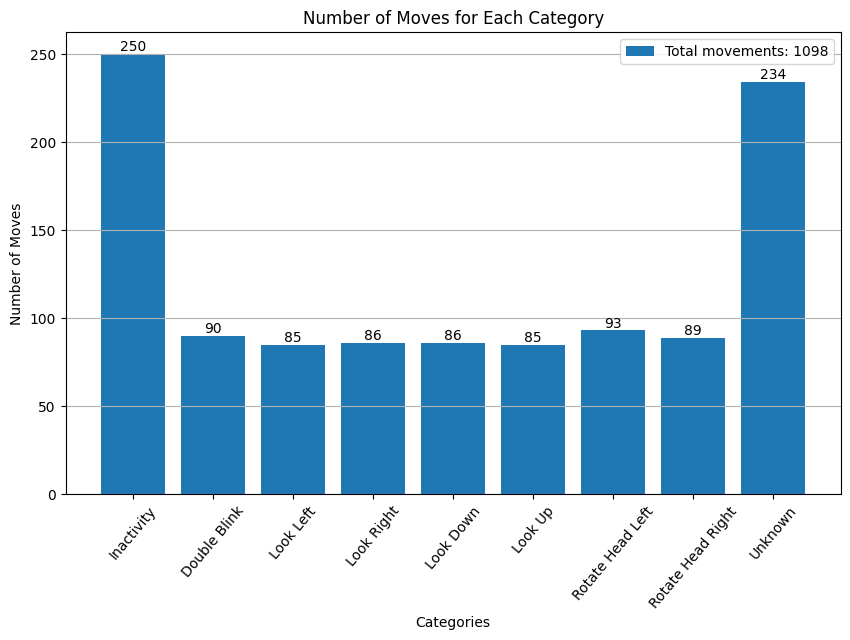

user1 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (32, 12, 9, 12, 12, 12, 12, 12, 26)
user2 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (34, 12, 12, 10, 11, 11, 12, 12, 21)
user3 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (54, 12, 12, 12, 12, 11, 15, 12, 38)
user4 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (26, 12, 12, 12, 11, 11, 12, 12, 68)
user5 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate Head Right', 'Unknown') (33, 18, 18, 16, 18, 20, 18, 17, 26)
user6 ('Inactivity', 'Double Blink', 'Look Left', 'Look Right', 'Look Down', 'Look Up', 'Rotate Head Left', 'Rotate 

In [5]:
%matplotlib inline

# Set Directory/Folder paths
FRAGMENTS_FOLDER_PATH = "MY_DATA\Labeled_Fragments"

# Load Data from all users
fragments, fragments_id = load_raw_fragments(FRAGMENTS_FOLDER_PATH, LABEL_NAMES, show_plot = True)

# Load Data from each user
USERS = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7']
data_per_user = {}
for user in USERS:
    user_fragments, user_fragments_id = load_raw_fragments(FRAGMENTS_FOLDER_PATH, LABEL_NAMES, choose_user=user, show_plot=False)
    data_per_user[user] = {'fragments': user_fragments, 'fragments_id': user_fragments_id}

__________________________________________________________________________________________________________________________________

# Signal Analysis

### Create diagrams
From each user, the first three movements of each category are randomly selected in order to be studied through diagrams in time domain and frequency domain.

In [7]:
USERS = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7']
LABEL_NAMES = [ "Inactivity",
                "Double Blink", "Look Left", "Look Right", "Look Down", "Look Up",
                "Rotate Head Left", "Rotate Head Right",
                "Unknown"]

for user in USERS:
    for i in range(8): # For all categories except Unknonw
        for j in range(3): # Take the first 3 moves of the category
            filename = user + "_" + LABEL_NAMES[i] + "_" + str(j) + ".png"

            movement = get_dataframes_by_label(
                data_per_user[user]['fragments'], # Dataframe
                data_per_user[user]['fragments_id'], # Label
                i)[j] # Category (i) and number of moves of this category (j)

            plot_movement(movement,channels=['AF7', 'AF8', 'TP9', 'TP10', 'X', 'Y', 'Z'],save_dir = "Images/movement_diagrams",filename=filename)

# Preprocessing

- Applying processing steps to an EEG signal to show the preprocessing flow:

Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 169 samples (0.660 s)



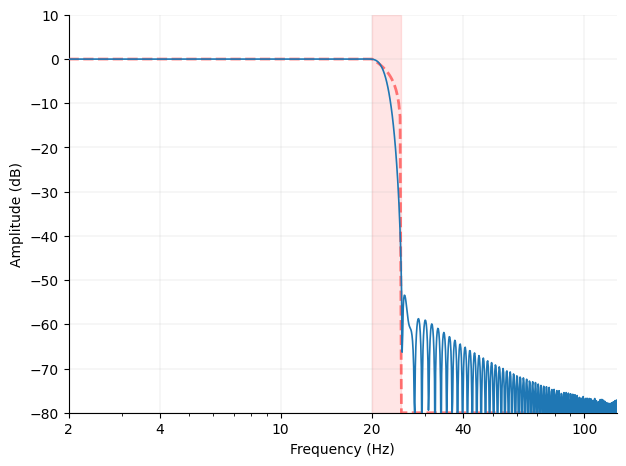

Filtering


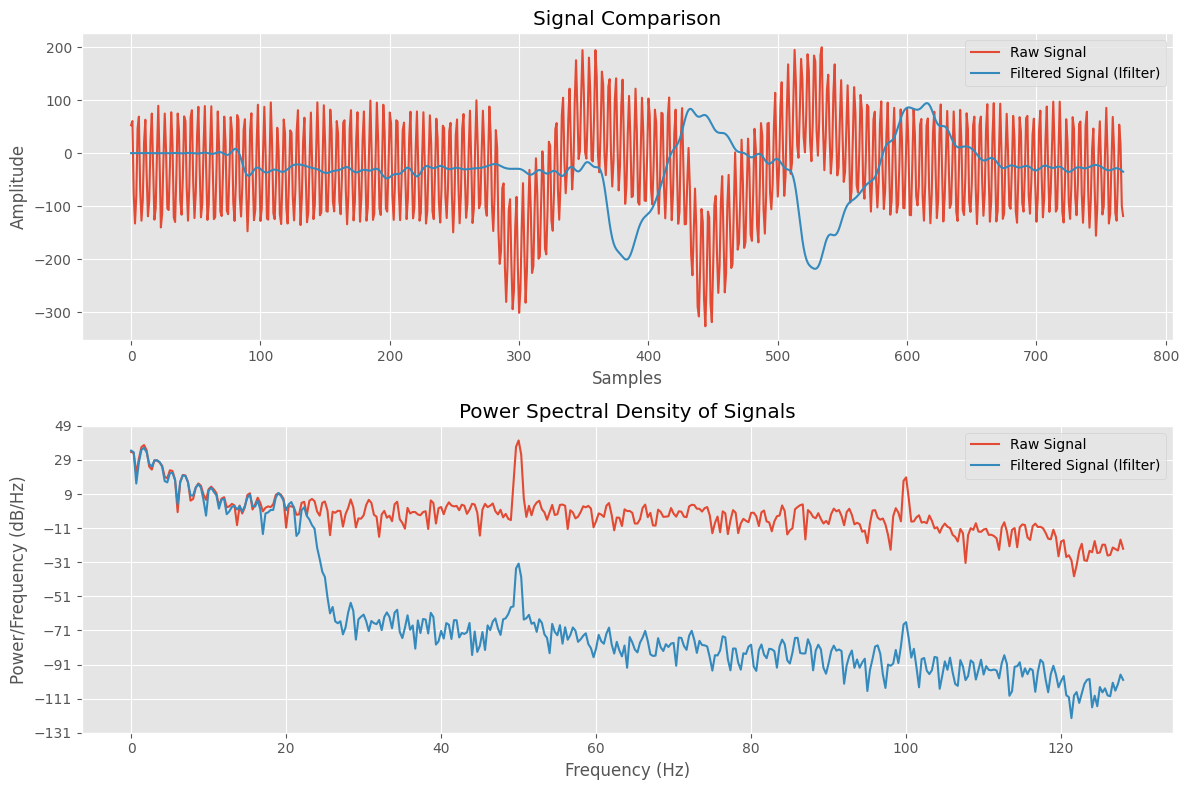

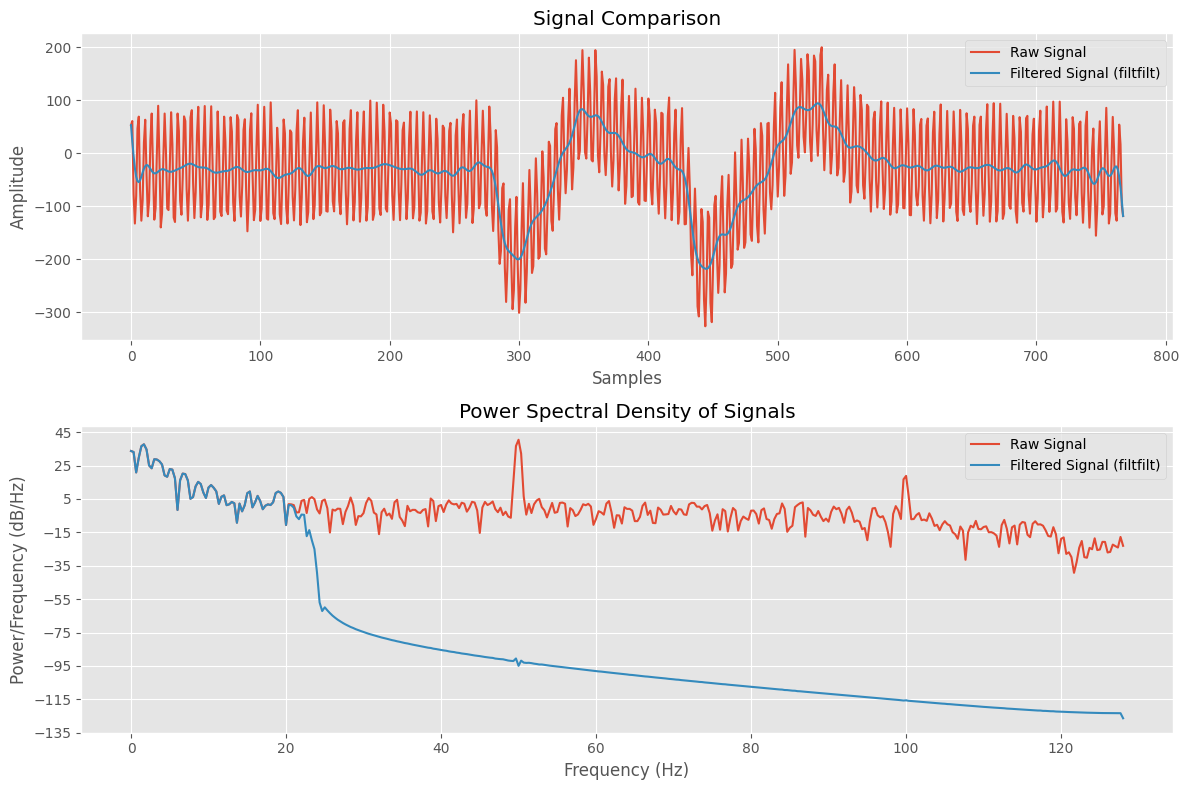

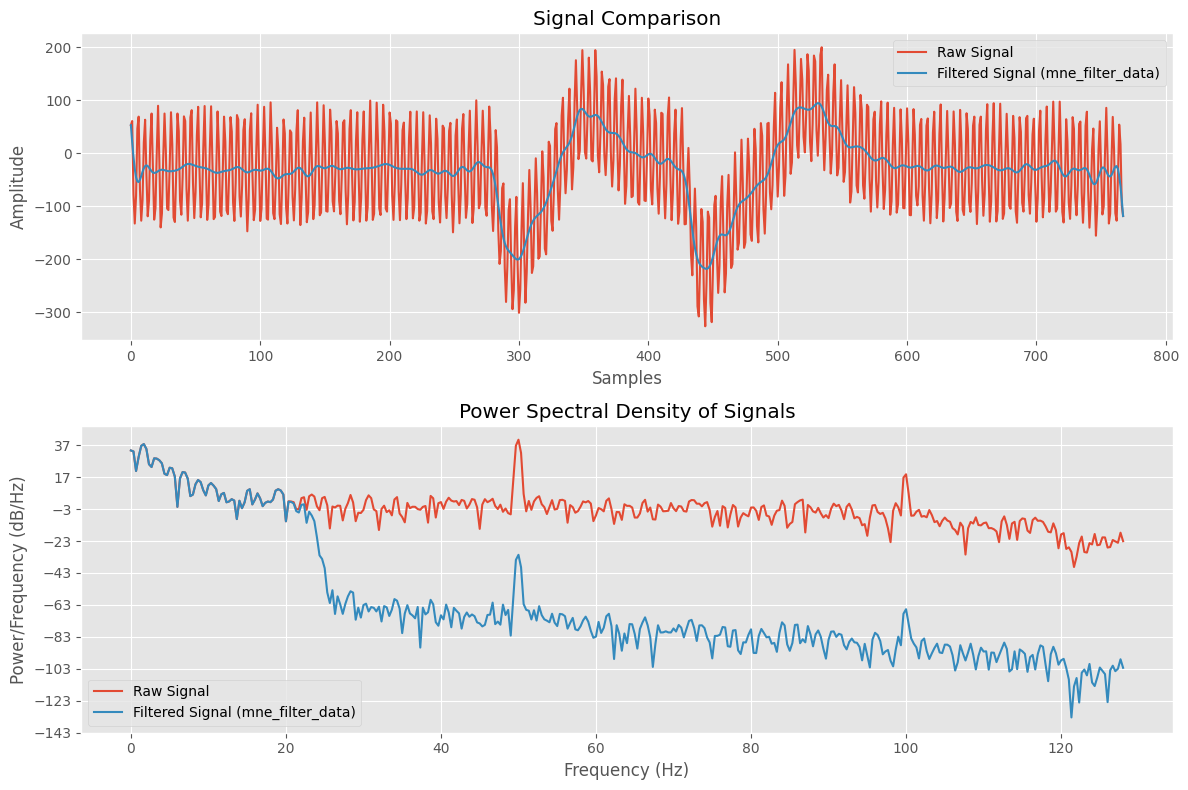

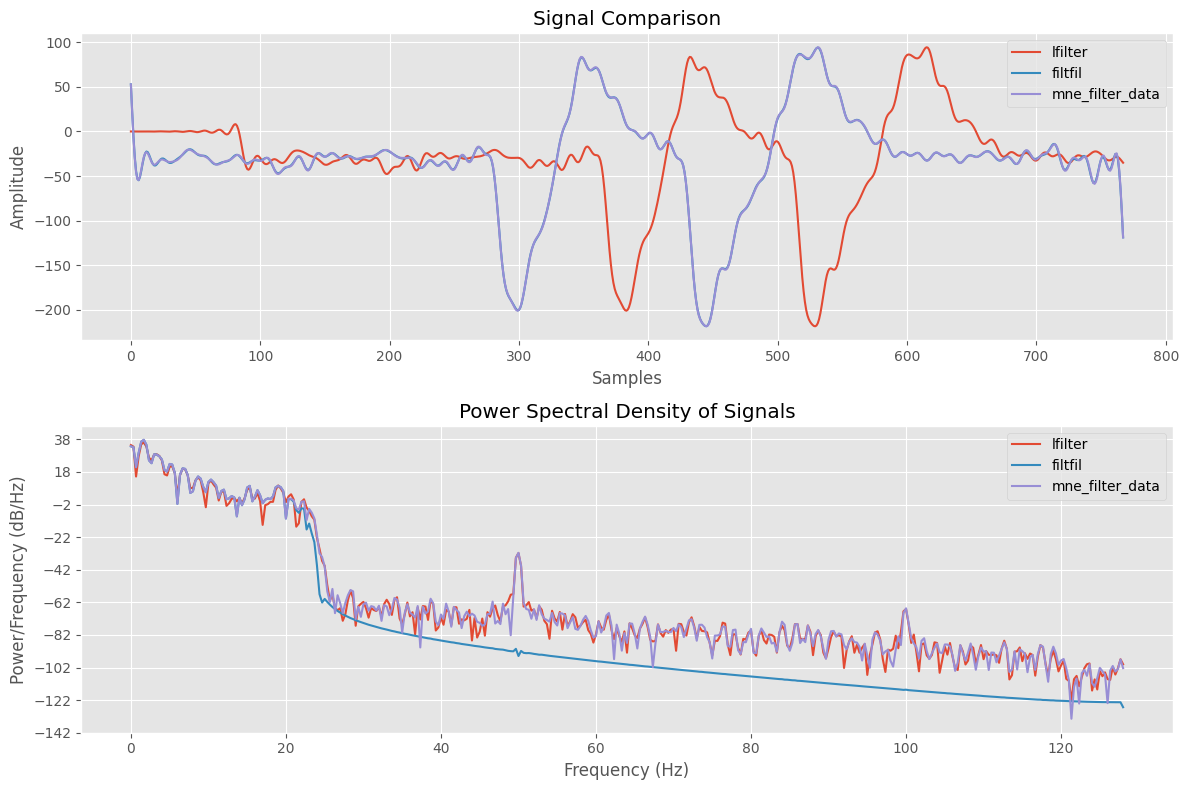

Remove DC Offset


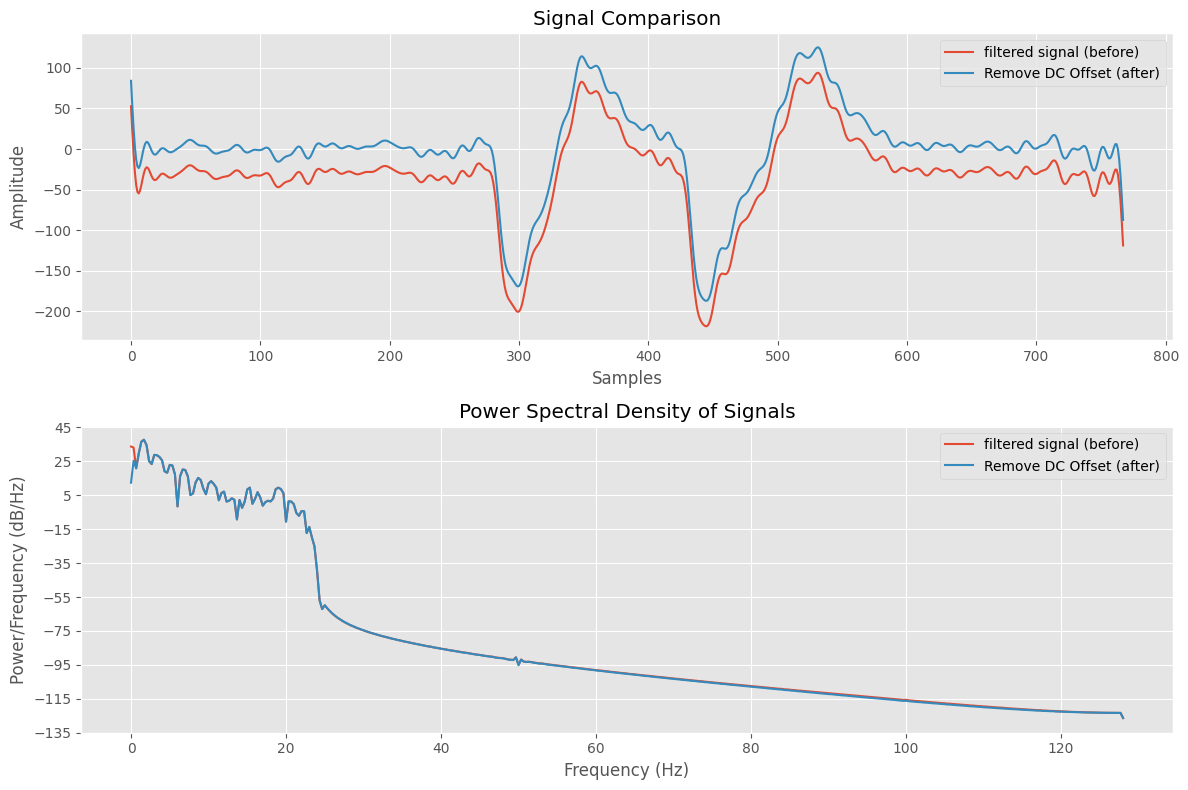

Resample


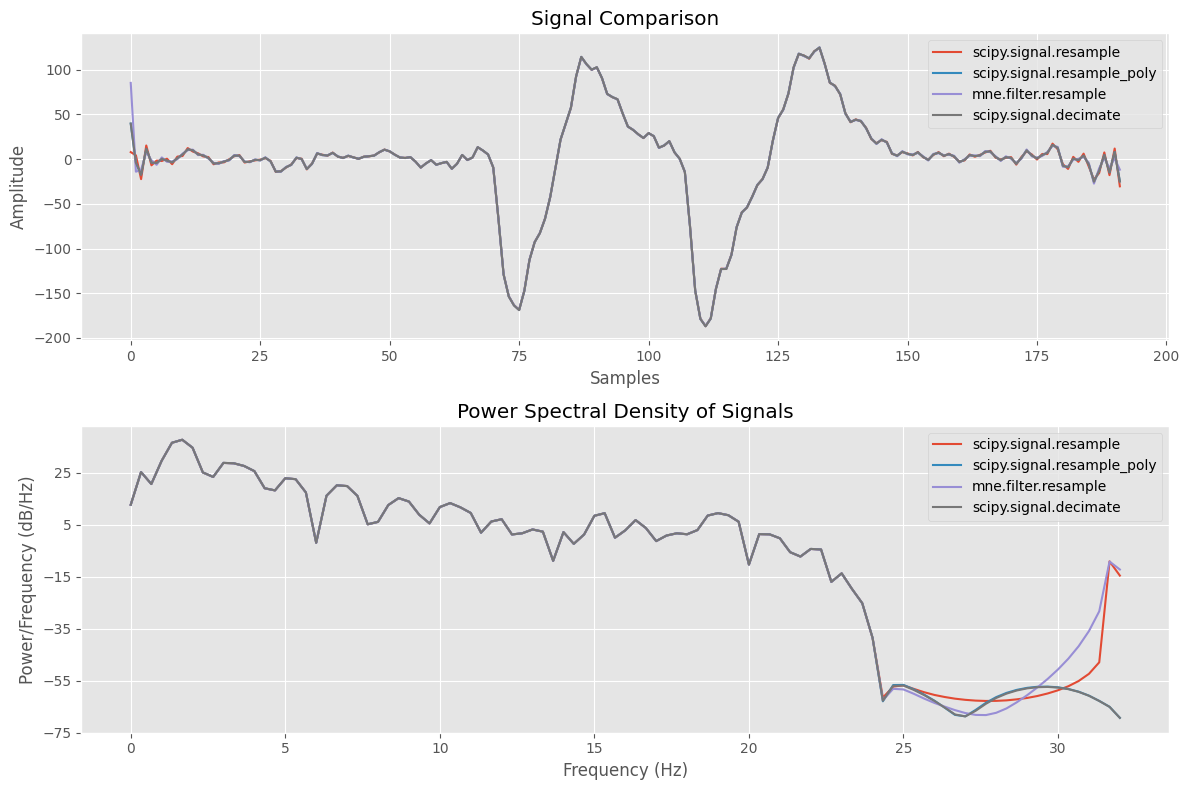

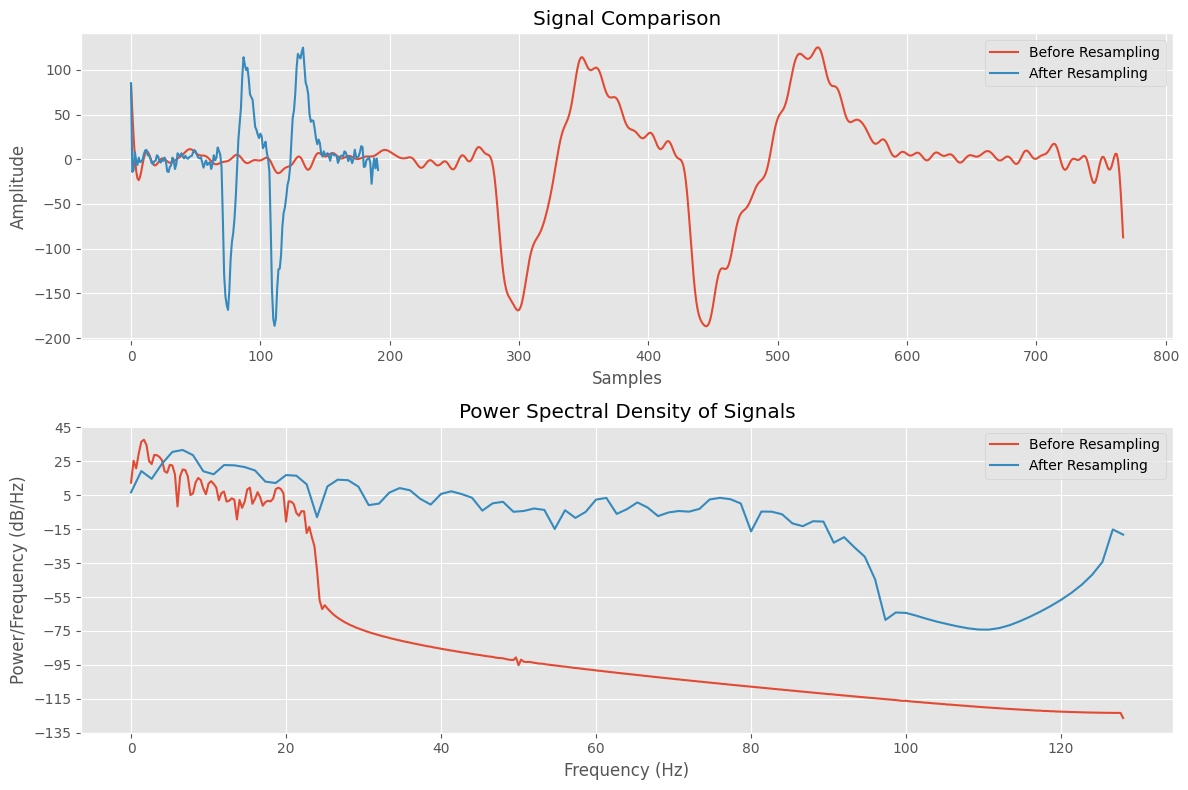

In [8]:
%matplotlib inline
# Here we take as example the TP10 signal from a Double Blink movement.
raw_signal = get_dataframes_by_label(fragments, fragments_id, 1)[0]["TP9"]
#raw_signal = get_dataframes_by_label(fragments, fragments_id, 1)[0]["TP10"]
raw_signal = raw_signal.values

########################################################################################################################

# Design a lowpass FIR filter at 20Hz using MNE and save the filter coefficients (1D ndarray for FIR filter)
filter_coeffs = mne.filter.create_filter(raw_signal, sfreq = 256, l_freq=None, h_freq=20,
                                        fir_design='firwin', fir_window='hamming', filter_length='auto')
# Plot the filter properties
nyq = 256 / 2.0  # the Nyquist frequency is half our sample rate
#freq = [0, f_p, f_s, nyq]
#gain = [1, 1, 0, 0]
mne.viz.plot_filter(filter_coeffs, sfreq=256, freq =[0, 20, 25, nyq], gain = [1, 1, 0, 0], plot=('magnitude'))

# Check differnet functions to apply the filter coefficients to the signal
print("Filtering")
# Apply the filter using scipy.signal.lfilter()
filtered_signal_lfilter = lfilter(filter_coeffs, [1.0], raw_signal) # lfilter() is causal and may introduce a phase shift

# Apply the filter using scipy.signal.filtfilt()
filtered_signal_filtfilt = filtfilt(filter_coeffs, [1.0], raw_signal) # filtfilt() is non-causal and zero-phase.

# Apply the filter mne.filter.filter_data() with phase='zero'
filtered_signal_mne_filter_data = mne.filter.filter_data(raw_signal,
                                                    sfreq = 256, l_freq = None, h_freq = 20,
                                                    fir_design='firwin', fir_window='hamming', filter_length='auto', phase='zero', # phase='zero-double' is the same as filtfilt()
                                                    verbose = 'error')

plot_signals_comparison([raw_signal,filtered_signal_lfilter],["Raw Signal","Filtered Signal (lfilter)"],fs=256)
plot_signals_comparison([raw_signal,filtered_signal_filtfilt],["Raw Signal","Filtered Signal (filtfilt)"],fs=256)
plot_signals_comparison([raw_signal,filtered_signal_mne_filter_data],["Raw Signal","Filtered Signal (mne_filter_data)"],fs=256)
plot_signals_comparison([filtered_signal_lfilter,filtered_signal_filtfilt,filtered_signal_mne_filter_data],["lfilter","filtfil","mne_filter_data"],fs=256)

########################################################################################################################

print("Remove DC Offset")
dc_offset_removed_signal = filtered_signal_filtfilt - np.mean(filtered_signal_filtfilt)
plot_signals_comparison([filtered_signal_filtfilt,dc_offset_removed_signal],["filtered signal (before)","Remove DC Offset (after)"],fs=256)

########################################################################################################################

resampled_signal_1 = resample(dc_offset_removed_signal, int(len(dc_offset_removed_signal) * 64/256)) # Using scipy.signal.resample
resampled_signal_2 = resample_poly(dc_offset_removed_signal, 64, 256) # Using scipy.signal.resample_poly
resampled_signal_3 = mne.filter.resample(dc_offset_removed_signal, 64, 256) # Using mne.filter.resample (is the same with scipy.signal.resample)
resampled_signal_4 = decimate(dc_offset_removed_signal, q=4, ftype='fir') # Using mne.filter.resample (is the same with scipy.signal.resample)


print("Resample")
plot_signals_comparison([resampled_signal_1,resampled_signal_2,resampled_signal_3,resampled_signal_4],["scipy.signal.resample","scipy.signal.resample_poly","mne.filter.resample","scipy.signal.decimate"],fs=64)
plot_signals_comparison([dc_offset_removed_signal,resampled_signal_3],["Before Resampling","After Resampling"],fs=256)


- Applying processing steps to the whole dataset using __preprocess_movement()__:


In [9]:
# Select Channels you want to use
EEG_CHANNELS = ['AF7','AF8','TP9','TP10']
GS_CHANNELS = ['X','Z']

def preprocess_movement(fragment,filter_coeffs):

    # Step 1 Remove the Y channel of each dataframe
    fragment_no_y = fragment[EEG_CHANNELS + GS_CHANNELS]
    # Init resampled_movement dataframe
    resampled_movement = pd.DataFrame()
    start_preprocessing_time = time.time() # Start preprocessing time
    for column in fragment_no_y.columns:
        signal = fragment_no_y[column].values # Extract each channel/signal
        
        # Step 2: Filtering the signals to remove high frequency noise
        filtered_signal = mne.filter.filter_data(signal, sfreq = 256, l_freq = None, h_freq = 20,
                                                method = 'fir', filter_length = 'auto', fir_design = 'firwin', fir_window='hamming', phase='zero', # Same as filtfilt()
                                                verbose = 'error')
       
        #filtered_signal = filtfilt(filter_coeffs, [1.0], signal) # filtfilt() is non-causal and zero-phase.
        
        # Step 3: Apply Mean filter to remove DC offset
        filtered_signal = filtered_signal - np.mean(filtered_signal)

        # Step 4: Resampling from 256 Hz to 64 Hz
        resampled_signal = mne.filter.resample(filtered_signal, 64, 256)
        
        # Save it back to the new dataframe and set the preprocessed dataframe column names
        resampled_movement[column] = resampled_signal
        resampled_movement = pd.DataFrame(resampled_movement, columns=EEG_CHANNELS + GS_CHANNELS)
    end_preprocessing_time = time.time() # End preprocessing time
    preprocessing_time = end_preprocessing_time - start_preprocessing_time
    return resampled_movement, preprocessing_time

# Design a lowpass FIR filter at 20Hz using MNE and save the filter coefficients (1D ndarray for FIR filter)
filter_coeffs = mne.filter.create_filter(raw_signal, sfreq = 256, l_freq=None, h_freq=20,
                                        fir_design='firwin', fir_window='hamming', filter_length='auto')

# Preprocessing all the dataframes
preprocessed_fragments = [] # Keep the preprocessing data for each movement
keep_preprocessing_times = [] # Keep the preprocessing time of each fragment

for fragment in fragments:
    preprocessed_fragment, preprocessing_time = preprocess_movement(fragment,filter_coeffs)
    preprocessed_fragments.append(preprocessed_fragment)
    keep_preprocessing_times.append(preprocessing_time)
# Print the average preprocessing time for each sample in (ms) and return the preprocessed fragments in a list
print("Average preprocessing time for each sample in (ms):", 1000*np.mean(keep_preprocessing_times))
print("preprocessed Fragments:", len(preprocessed_fragments))

# Preprocessing Data from each user
preprocessed_data_per_user = {}
for user in USERS:
    user_preprocessed_fragments = []

    for user_fragment in data_per_user[user]['fragments']:
        preprocessed_user_fragment, preprocessing_time = preprocess_movement(user_fragment,filter_coeffs)
        user_preprocessed_fragments.append(preprocessed_user_fragment)

    preprocessed_data_per_user[user] = {'processed_fragments': user_preprocessed_fragments, 'fragments_id': data_per_user[user]['fragments_id']}

Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 169 samples (0.660 s)

Average preprocessing time for each sample in (ms): 19.287964468228147
preprocessed Fragments: 1098


In [10]:
print("Total Number of Preprocessed Movements: " + str(len(preprocessed_fragments)))
print("Preprocessed Movement (Dataframe) Shape: (timesteps, channels) = " + str(preprocessed_fragments[0].shape))

Total Number of Preprocessed Movements: 1098
Preprocessed Movement (Dataframe) Shape: (timesteps, channels) = (192, 6)


#### Create digrams for preprocessed movements

In [11]:
for user in USERS:
    for i in range(8): # For all categories except Unknonw
        for j in range(2): # Take the first 2 moves of the category
            filename = user + "_" + LABEL_NAMES[i] + "_" + str(j) + ".png"

            movement = get_dataframes_by_label(
                preprocessed_data_per_user[user]['processed_fragments'], # Dataframe
                preprocessed_data_per_user[user]['fragments_id'], # Label
                i)[j] # Category and number of moves of this category

            plot_movement(movement,channels=['AF7', 'AF8', 'TP9', 'TP10', 'X', 'Z'], fs=64, save_dir = "Images/preprocessed_fragments",filename=filename)

__________________________________________________________________________________________________________________________________

# Split Data

In [21]:
%matplotlib qt

# Function to save split data to pickle files
def save_split_data(data, folder_path, filename):
    if not os.path.exists(folder_path): os.makedirs(folder_path)
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'wb') as file: pickle.dump(data, file)


# Holdout Split 80-20
X_train, X_test, y_train, y_test = train_test_split(preprocessed_fragments, fragments_id, test_size=0.2, random_state=42,stratify=fragments_id)
plot_holdout_split(X_train, X_test, y_train, y_test)

save_split_data((X_train, X_test, y_train, y_test),"MY_DATA\Split_Data","holdout_80_20_split_data.pkl")

# Cross Validation Train Data Split
stratified_cv_model = StratifiedKFold(n_splits=6, shuffle=True, random_state=42) # Initialize StratifiedKFold
plot_cv_class_distribution_per_fold(stratified_cv_model,X_train,y_train) # Plot Class Distribution per Fold

# Create Folds
cv_train_val_data = []
for train_index, test_index in stratified_cv_model.split(X_train, y_train):
    # Splitting the dataset into the Training set and Test set
    X_train_folds, X_val_fold = [X_train[i] for i in train_index], [X_train[i] for i in test_index]
    y_train_folds, y_val_fold = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

    cv_train_val_data.append(((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)))

# Now, cv_train_val_data is a list of tuples, where each tuple is in the form ((X_train, y_train), (X_val, y_val))
# where X_train, X_val are lists containing the training and validation dataframes and
# y_train, y_val are lists containing the training and validation labels
# We can access each fold like this: (X_train, y_train), (X_test, y_test) = cv_train_val_data[0]

save_split_data(cv_train_val_data,"MY_DATA\Split_Data","cv_split_data.pkl")

______________________________________________________

# Classicfication

### Load Data

In [3]:
# Function to load split data from pickle files
def load_split_data(folder_path, filename):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

cv_train_val_data = load_split_data("MY_DATA\Split_Data","cv_split_data.pkl")
X_train, X_test, y_train, y_test = load_split_data("MY_DATA\Split_Data","holdout_80_20_split_data.pkl")
#plt.plot(X_train[1]) # Check

### Define Common Hyperparameters for all models

In [14]:
EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
DROPOUT_SIZE = 0.2
LOSS_FUNCTION = 'sparse_categorical_crossentropy'

## MLP Model

- features extraction from signals for MLP classifier

In [15]:
def feature_extraction(sample, label):
    def calc_Mean(input_signal:np):
        return np.mean(input_signal)

    def calc_StD(input_signal:np):
        return np.std(input_signal)

    def calc_RMS(input_signal:np):
        return np.sqrt(np.mean(input_signal**2))

    def calc_Min(input_signal:np):
        return np.min(input_signal)

    def calc_Max(input_signal:np):
        return np.max(input_signal)

    def pos_Min(input_signal:np):
        return np.argmin(input_signal)

    def pos_Max(input_signal:np):
        return np.argmax(input_signal)

    def calc_pk2pk(input_signal:np):
        return np.ptp(input_signal)

    def calc_Skewness(input_signal:np):
        return stats.skew(input_signal)

    def calc_Kurtosis(input_signal:np):
        return stats.kurtosis(input_signal)

    def calc_Power(input_signal:np):
        return np.mean(input_signal**2)

    def calc_Hjorth_Activity(input_signal:np):
        return np.var(input_signal)

    def calc_Hjorth_Mobility(input_signal:np):
        return np.sqrt(np.var(np.diff(input_signal))/np.var(input_signal))

    def calc_Hjorth_Complexity(input_signal:np):
        return (calc_Hjorth_Mobility(np.diff(input_signal))/calc_Hjorth_Mobility(input_signal))

    features = {} # Init dictionary to hold the features for a signal
    # Calculate each feature and add it to the dictionary
    for column in sample.columns:
        signal_data = sample[column].to_numpy()
        features[column + '_RMS'] = calc_RMS(signal_data)
        features[column + '_Min'] = calc_Min(signal_data)
        features[column + '_Max'] = calc_Max(signal_data)
        features[column + '_Peak_to_Peak'] = calc_pk2pk(signal_data)
        features[column + '_Skewness'] = calc_Skewness(signal_data)
        features[column + '_Kurtosis'] = calc_Kurtosis(signal_data)
        features[column + '_Activity'] = calc_Hjorth_Activity(signal_data)
        features[column + '_Mobility'] = calc_Hjorth_Mobility(signal_data)
        features[column + '_Complexity'] = calc_Hjorth_Complexity(signal_data)
    features['Label'] = label # Add the 'Label' column to the features
    return features

def create_data_for_MLP(X:list, y, show_feature_extraction_time=False, return_dataframe = False):
    feature_vectors = [] # Init list to hold the feature vector for each sample
    time_for_each_sample= [] # Init list to store time taken for featrue calculation for each sample
    for i in range(len(X)):
        start_time = time.time() # Start total time calculation
        feature_vectors.append(feature_extraction(X[i],y[i]))
        end_time = time.time() # End time calculation for this sample
        time_for_each_sample.append(end_time - start_time)

    if (show_feature_extraction_time):
        mean_feature_extraction_time = np.mean(time_for_each_sample) * 1000 # Calculate the mean time
        print(f"Mean time for feature extraction per Sample (Total Samples: {len(time_for_each_sample)}): {mean_feature_extraction_time:.3f} ms")

    feature_vectors_df = pd.DataFrame(feature_vectors) # Convert the feature vectors to a DataFrame
    if(return_dataframe): return feature_vectors_df
    else:
        # Split into X (data) and y (labels) and return in numpy arrays
        return feature_vectors_df.iloc[:, :-1].values, feature_vectors_df.iloc[:, -1].values

In [38]:
create_data_for_MLP(X_train_folds, y_train_folds, return_dataframe = True)

AF7_RMS     AF7_Min     AF7_Max  AF7_Peak_to_Peak  AF7_Skewness  \
0     23.063563  -66.452509  105.051886        171.504395      0.746709   
1      8.994485  -18.919905   34.898554         53.818458      1.122884   
2     21.926144  -54.263669   87.505861        141.769530      1.353773   
3     22.382754  -78.104264  104.671727        182.775991      1.866142   
4      3.584387  -10.532131    9.039827         19.571957     -0.180924   
..          ...         ...         ...               ...           ...   
727    4.991536  -11.132307   14.132743         25.265050      0.187320   
728   21.051292  -71.783512   69.443834        141.227345     -0.416836   
729  229.734562 -285.218730  974.216165       1259.434895      2.374179   
730  106.265862  -64.474053  634.453283        698.927336      4.228305   
731    7.000179  -15.716997   35.249127         50.966124      1.436516   

     AF7_Kurtosis  AF7_Activity  AF7_Mobility  AF7_Complexity    AF8_RMS  ...  \
0        5.541047    531.927828      0.402206        2.341664  24.227112  ...   
1        2.825674     80.900736      0.599648        2.324117   9.954726  ...   
2        4.001523    480.755070      0.351768        2.785843  18.364758  ...   
3        9.435868    500.987208      0.387994        2.859952  13.971775  ...   
4        0.110711     12.847821      0.940825        1.518873   4.311877  ...   
..            ...           ...           ...             ...        ...  ...   
727     -0.335818     24.915371      0.796102        1.693038   4.669112  ...   
728      3.727391    443.156273      0.313397        3.345383  21.130787  ...   
729      6.040625  52777.949264      0.148334        4.531684  37.457274  ...   
730     18.429274  11292.432602      0.241977        2.543613   9.686112  ...   
731      5.715694     49.002354      0.651778        1.847844  16.829623  ...   

         Z_RMS      Z_Min       Z_Max  Z_Peak_to_Peak  Z_Skewness  Z_Kurtosis  \
0     0.393313  -1.172256    1.139919        2.312175   -0.348744    0.372202   
1    38.074817 -69.010447  104.609142      173.619589    0.691434    0.996976   
2    34.820535 -66.066468   68.667538      134.734007   -0.002429   -0.660100   
3     0.368925  -1.358918    1.034771        2.393689    0.096014    0.351372   
4     0.401011  -0.780638    1.159582        1.940220    0.606274   -0.095433   
..         ...        ...         ...             ...         ...         ...   
727   0.737096  -1.550702    1.889063        3.439765   -0.149857   -0.500473   
728  38.325502 -70.406118   76.933332      147.339450    0.171342   -0.351417   
729   0.742974  -2.914483    1.820263        4.734746   -1.750475    4.983317   
730   0.465422  -2.065215    0.955103        3.020318   -1.523411    4.227180   
731   0.385030  -0.815124    1.063205        1.878329   -0.119942   -0.324629   

      Z_Activity  Z_Mobility  Z_Complexity  Label  
0       0.154693    0.672645      1.703813      1  
1    1449.691679    0.149843      7.775492      6  
2    1212.469637    0.084119     11.175240      7  
3       0.136101    0.559749      2.041004      2  
4       0.160810    0.479178      2.431482      0  
..           ...         ...           ...    ...  
727     0.543308    0.427982      2.584379      0  
728  1468.844085    0.081873     11.627692      6  
729     0.552009    0.324166      3.063884      8  
730     0.216615    0.412509      2.623005      8  
731     0.148248    0.455480      2.378367      1  

[732 rows x 55 columns]

- MLP Training

Mean time for feature extraction per Sample (Total Samples: 731): 7.591 ms
------------------------------------------------------------------------
Input Shape: (731, 54)
Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14080     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropou

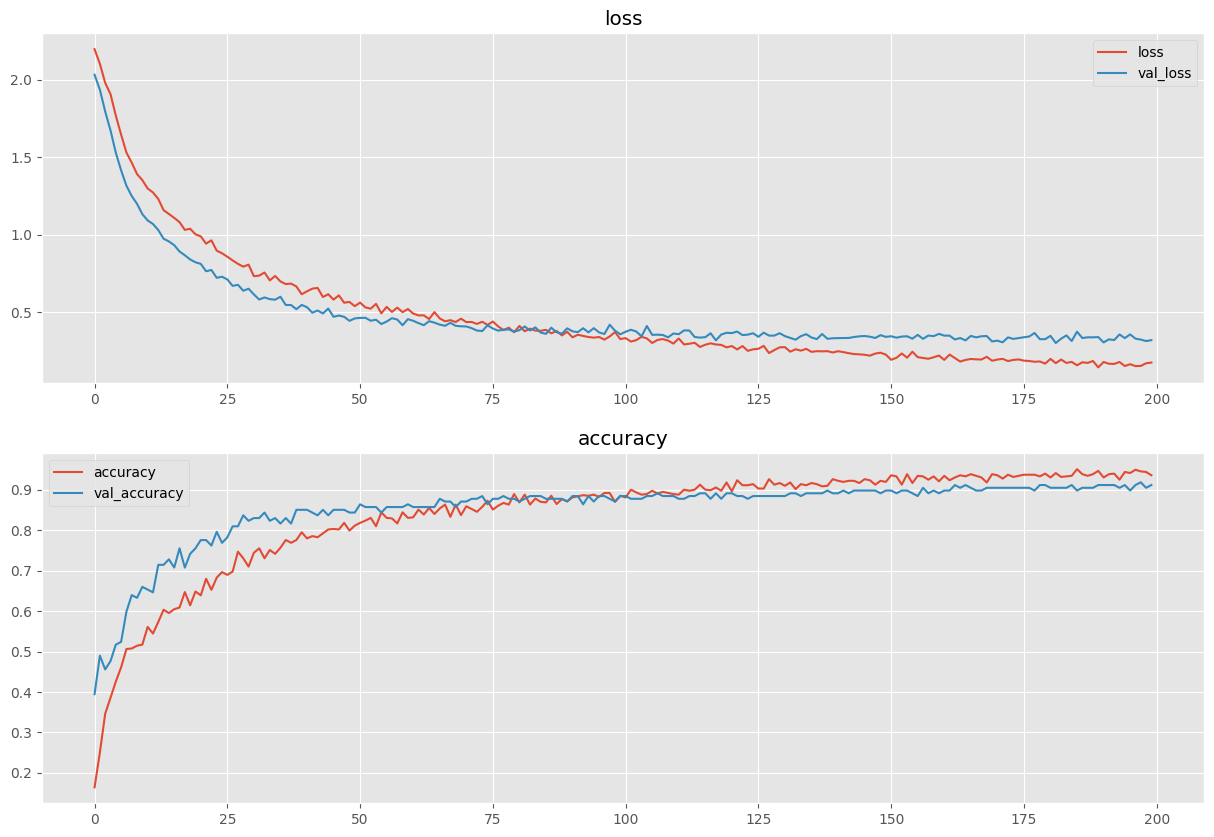

Validation Loss:  0.32122471928596497
Validation Accuracy: 91.16%
Test Loss:  0.3168196678161621
Test Accuracy: 89.09%
INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_1\assets
Mean time for feature extraction per Sample (Total Samples: 731): 7.464 ms
CV Iteration 2/6


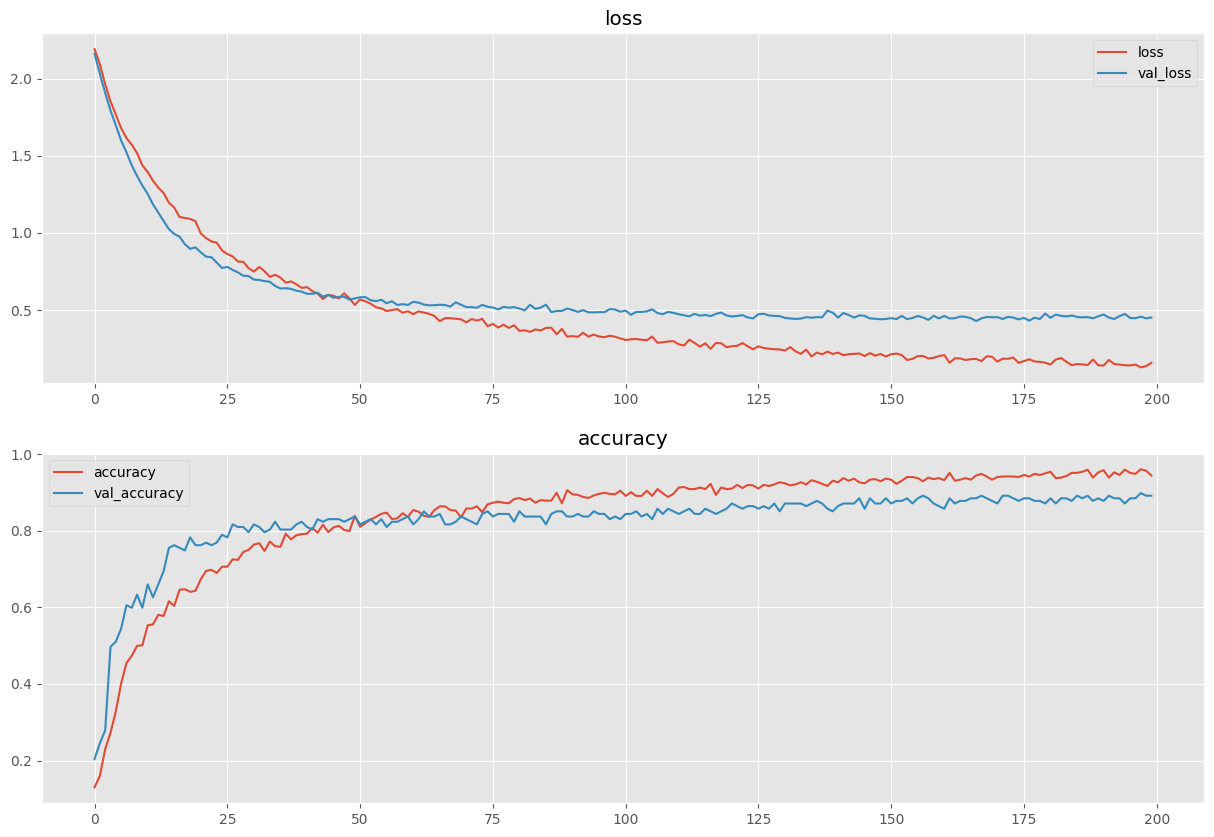

Validation Loss:  0.4514910578727722
Validation Accuracy: 89.12%
Test Loss:  0.331694632768631
Test Accuracy: 89.09%
INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_2\assets
Mean time for feature extraction per Sample (Total Samples: 732): 7.436 ms
CV Iteration 3/6


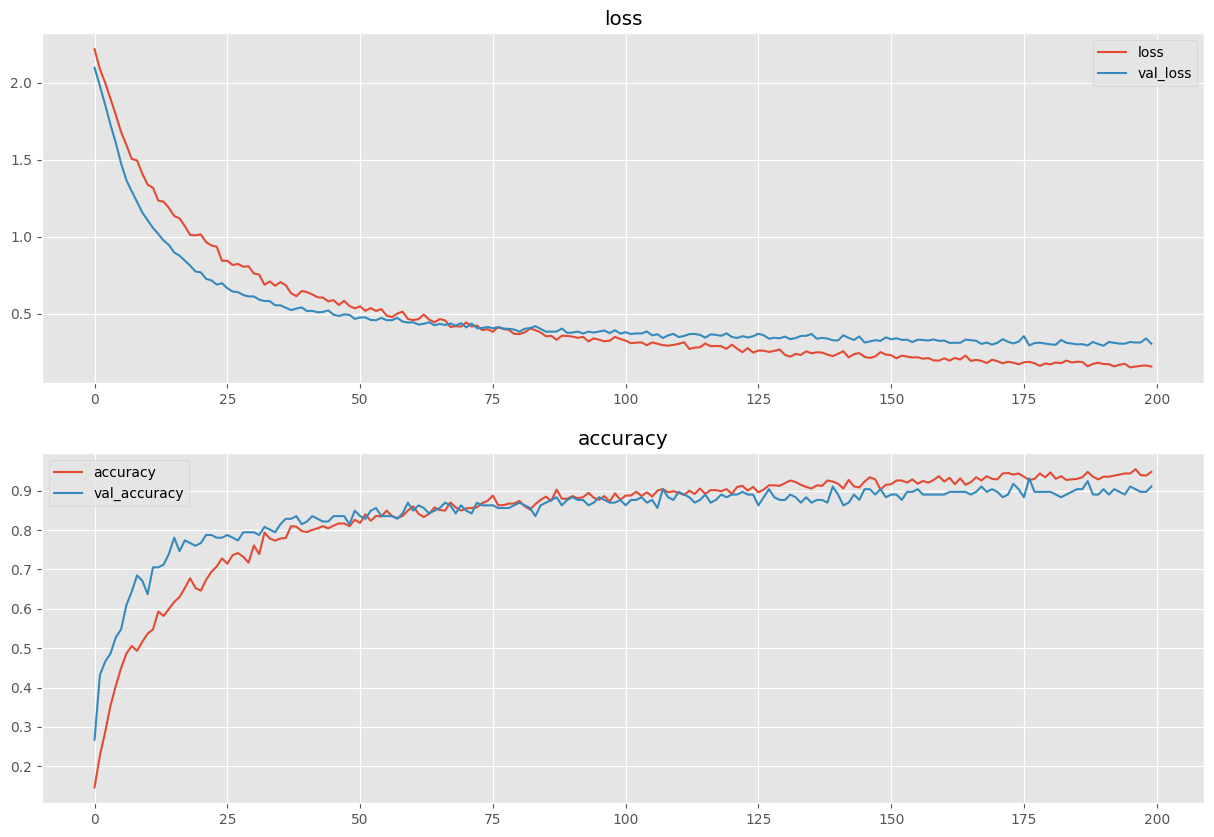

Validation Loss:  0.3036339581012726
Validation Accuracy: 91.10%
Test Loss:  0.28771042823791504
Test Accuracy: 88.64%
INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_3\assets
Mean time for feature extraction per Sample (Total Samples: 732): 7.410 ms
CV Iteration 4/6


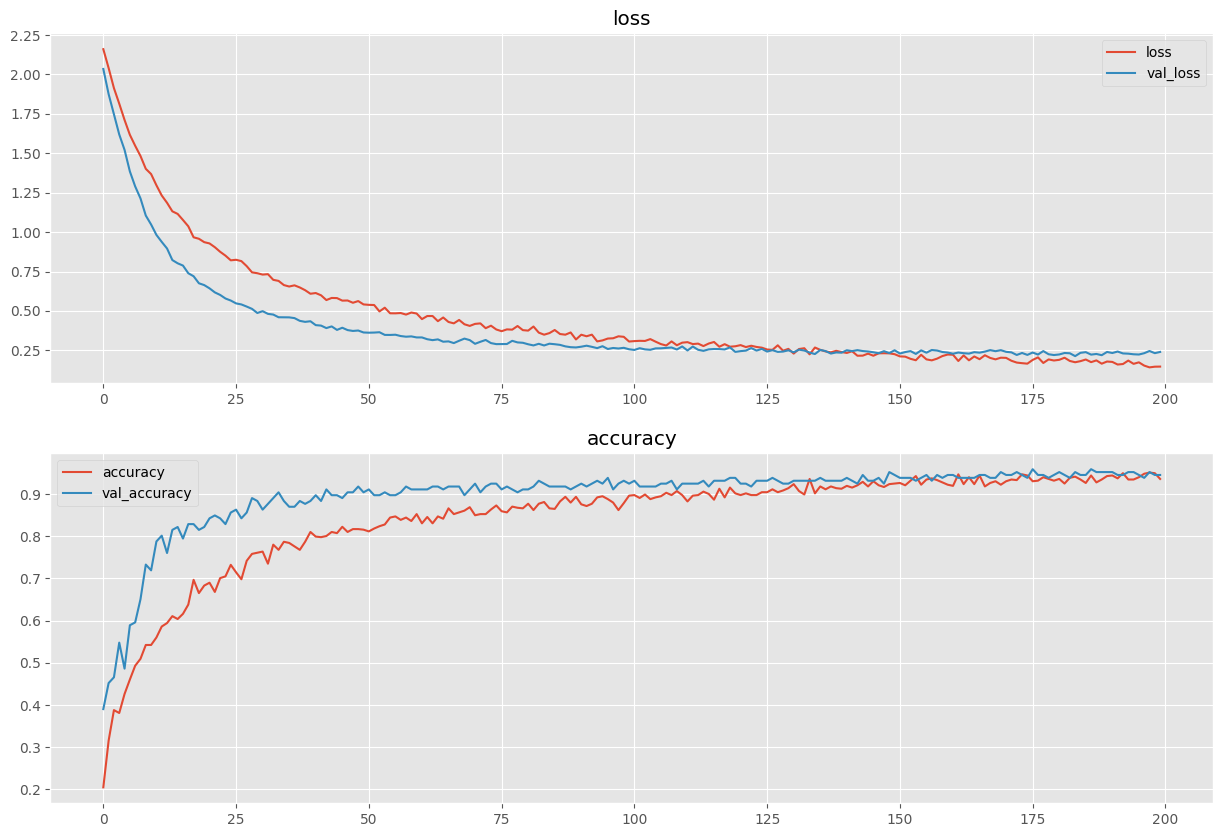

Validation Loss:  0.23989556729793549
Validation Accuracy: 94.52%
Test Loss:  0.2854052186012268
Test Accuracy: 90.91%
INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_4\assets
Mean time for feature extraction per Sample (Total Samples: 732): 7.483 ms
CV Iteration 5/6


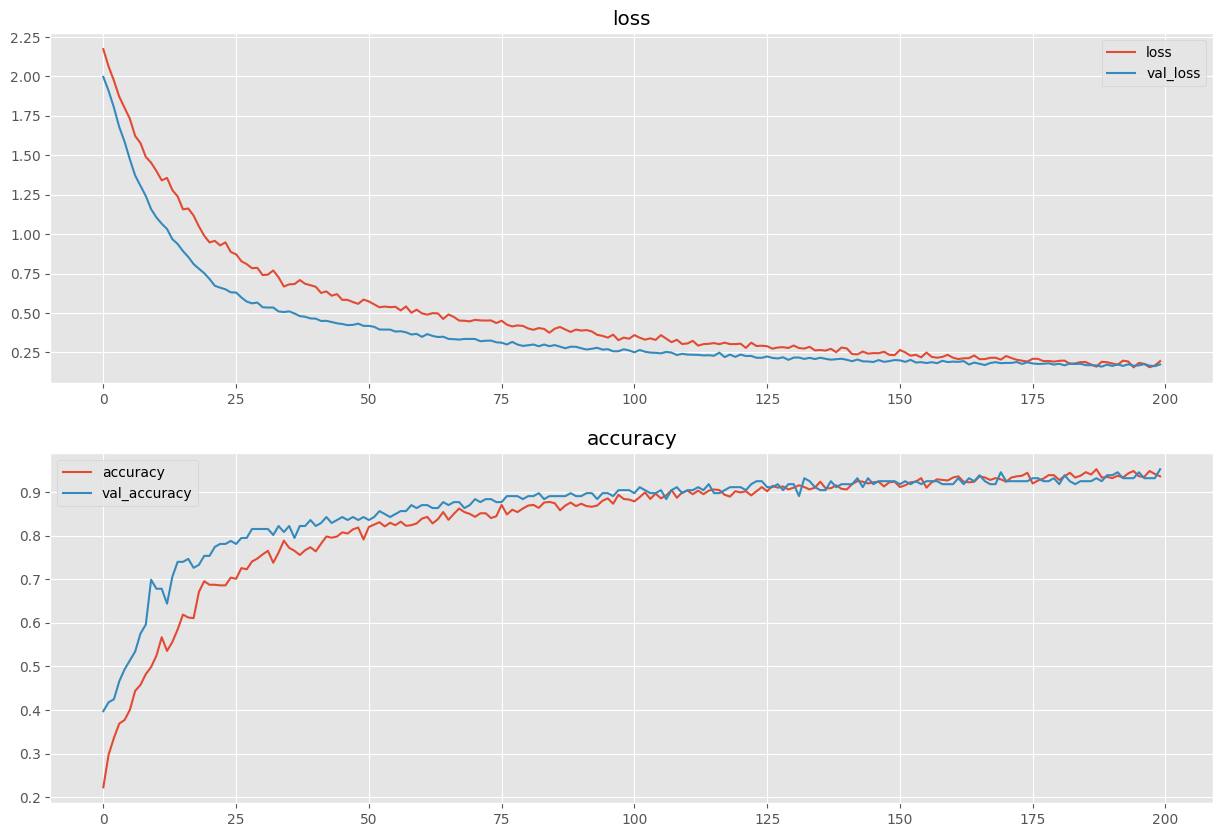

Validation Loss:  0.17392028868198395
Validation Accuracy: 95.21%
Test Loss:  0.3006318211555481
Test Accuracy: 89.55%
INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_5\assets
Mean time for feature extraction per Sample (Total Samples: 732): 7.341 ms
CV Iteration 6/6


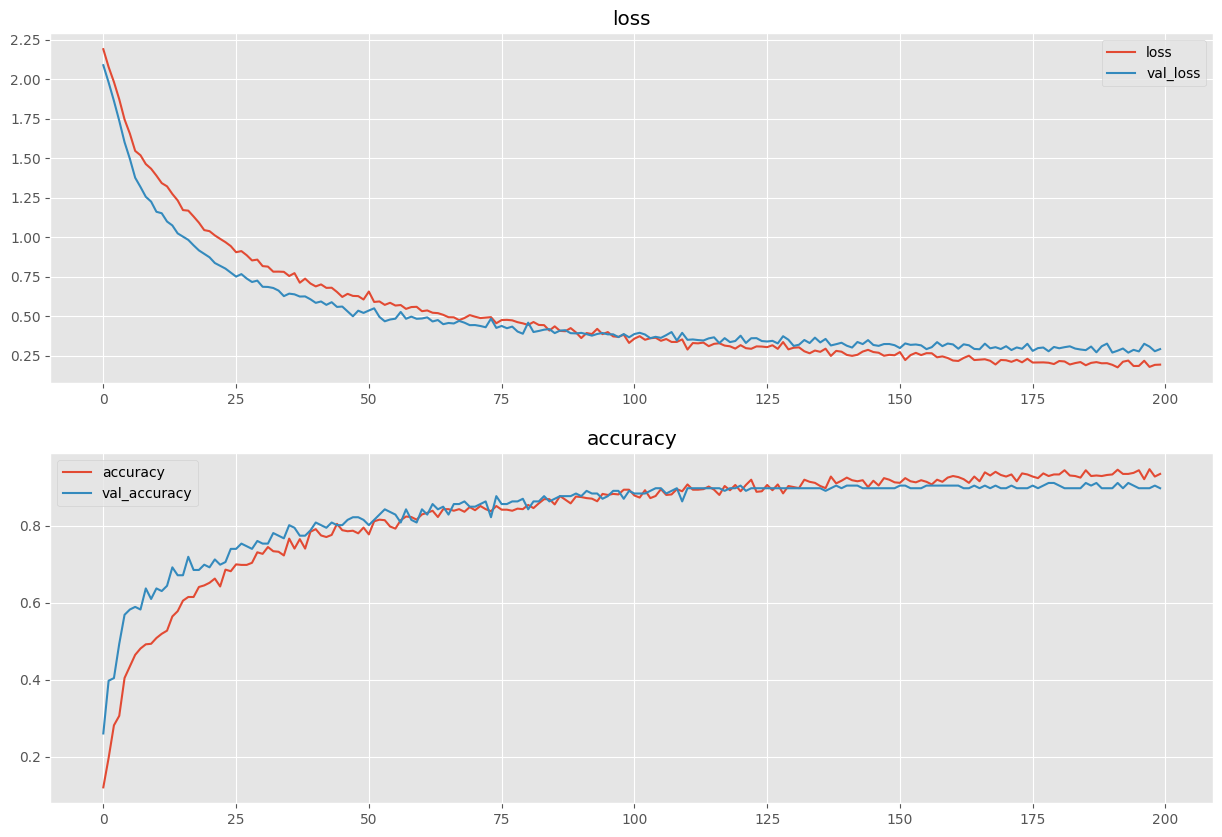

Validation Loss:  0.29155433177948
Validation Accuracy: 89.73%
Test Loss:  0.3010160028934479
Test Accuracy: 89.09%
INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_6\assets
------------------------------------------------------------------------
CV Mean Validation Loss: 0.29695332050323486
CV Mean Validation Accuracy: 91.80% sd: 2.29%
CV Mean Test Loss: 0.30387962857882184
CV Mean Test Accuracy: 89.39% sd: 0.73%


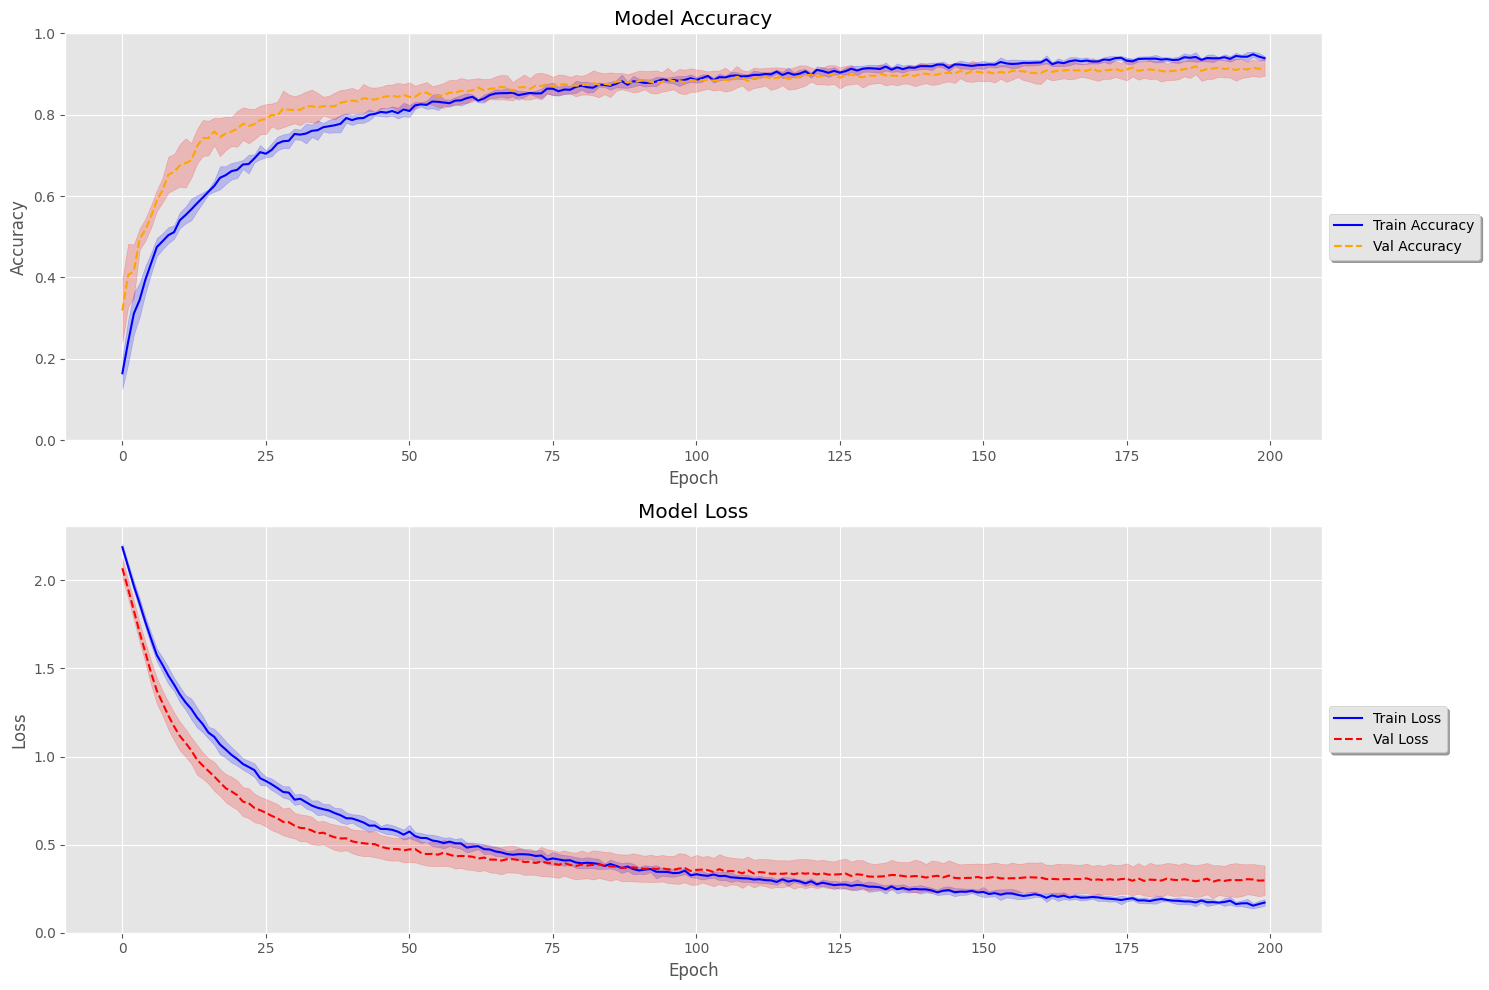

In [28]:
%matplotlib inline
def create_MLP_model(model_input:int, model_output:int):
    model = tf.keras.models.Sequential(name = 'MLP_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = (model_input)))
    # Hidden Layers
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    # Output Layer
    model.add(tf.keras.layers.Dense(model_output, activation='softmax'))

    # Compile the model
    model.compile(loss=LOSS_FUNCTION,
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])

    return model

mlp_cv_histories = [] # Save the history of each iteration in cv
mlp_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
mlp_cv_val_loss = [] # Save the validation loss of each iteration in cv
mlp_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
mlp_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Transforn data using feature extraction from signals for MLP
    mlp_X_train, mlp_y_train = create_data_for_MLP(X_train_folds, y_train_folds, show_feature_extraction_time=True)
    mlp_X_val, mlp_y_val = create_data_for_MLP(X_val_fold, y_val_fold)

    # Apply scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) # StandardScaler()
    mlp_X_train_scaled = scaler.fit_transform(mlp_X_train)
    mlp_X_val_scaled = scaler.transform(mlp_X_val)

    # Define input and outpout shape for the model
    input_size = mlp_X_train_scaled.shape[1]
    output_size = np.max(mlp_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_MLP_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(mlp_X_train_scaled.shape))
        print(model.summary())
        tf.keras.utils.plot_model(model,to_file="Images\models\MLP.png",show_layer_names=False,show_layer_activations=True,show_shapes=False,show_dtype=False,rankdir="TB",dpi=296)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(mlp_y_train), y=mlp_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    history = model.fit(x = mlp_X_train_scaled, y = mlp_y_train,
                        #validation_split = 0.2,
                        validation_data=(mlp_X_val_scaled, mlp_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    mlp_cv_histories.append(history.history)

    # Evaluate the model with the validation data for each CV Iteration
    val_scores = model.evaluate(mlp_X_val_scaled, mlp_y_val, verbose=0)
    print("Validation Loss: ",  (val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (val_scores[1]*100))
    mlp_cv_val_loss.append(val_scores[0])
    mlp_cv_val_accuracy.append(val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    mlp_X_test, mlp_y_test = create_data_for_MLP(X_test, y_test)
    mlp_X_test_scaled = scaler.transform(mlp_X_test)
    test_scores = model.evaluate(mlp_X_test_scaled, mlp_y_test, verbose=0)
    print("Test Loss: ",  (test_scores[0]))
    print("Test Accuracy: %.2f%%" % (test_scores[1]*100))
    mlp_cv_test_loss.append(test_scores[0])
    mlp_cv_test_accuracy.append(test_scores[1]*100)

    mlp_path = "MY_DATA\Keras_Models\MLP"
    model_filename = '\MLP-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(mlp_path): os.makedirs(mlp_path)
    model.save(mlp_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(mlp_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(mlp_cv_val_accuracy), np.std(mlp_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(mlp_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(mlp_cv_test_accuracy), np.std(mlp_cv_test_accuracy)))
plot_mean_histories(mlp_cv_histories)


- MLP Prediction

220/220 [==============================] - 1s 2ms/step

Correct predictions: 196/220


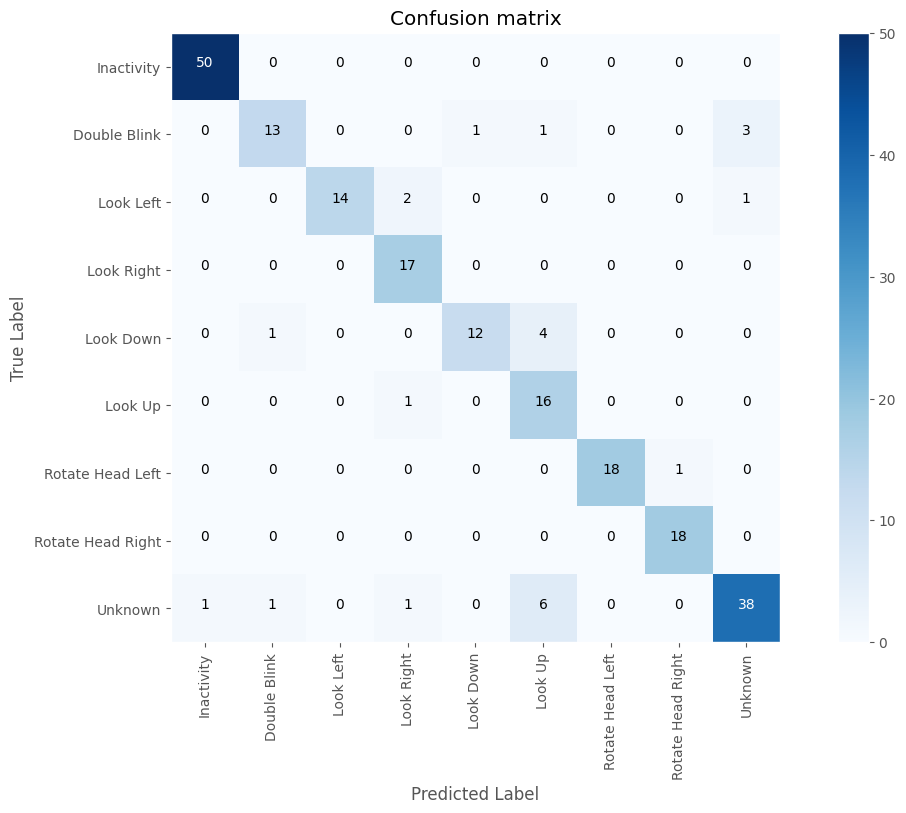

                   precision    recall  f1-score   support

       Inactivity       0.98      1.00      0.99        50
     Double Blink       0.87      0.72      0.79        18
        Look Left       1.00      0.82      0.90        17
       Look Right       0.81      1.00      0.89        17
        Look Down       0.92      0.71      0.80        17
          Look Up       0.59      0.94      0.73        17
 Rotate Head Left       1.00      0.95      0.97        19
Rotate Head Right       0.95      1.00      0.97        18
          Unknown       0.90      0.81      0.85        47

         accuracy                           0.89       220
        macro avg       0.89      0.88      0.88       220
     weighted avg       0.91      0.89      0.89       220

Predictions Threshold (80%) Pass:  172
Average prediction time for a sample in (ms): 44.15646466341885


In [29]:
loaded_mlp_model = tf.keras.models.load_model("MY_DATA\Keras_Models\MLP\MLP-CV_training_Iteration_1") # load the model iteration closer to the mean Accuracy

# Make predictions on the test data
mlp_predictions = np.argmax(loaded_mlp_model.predict(mlp_X_test_scaled, batch_size=1), axis=-1)
plot_Confusion_Matrix(mlp_y_test, mlp_predictions, LABEL_NAMES)
print(classification_report(mlp_y_test, mlp_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

mlp_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(mlp_X_test_scaled.shape[0]):
    move_to_predict = np.expand_dims(mlp_X_test_scaled[i], axis=0)
    start_time = time.time()
    mlp_sample_prediction = loaded_mlp_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(mlp_sample_prediction[0]) >= threshold and np.argmax(mlp_sample_prediction[0]) == mlp_y_test[i]): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    mlp_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(mlp_keep_inference_times))

## LSTM Model

------------------------------------------------------------------------
Input Shape: (731, 192, 6)
Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 192, 128)          69120     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 297       
                      

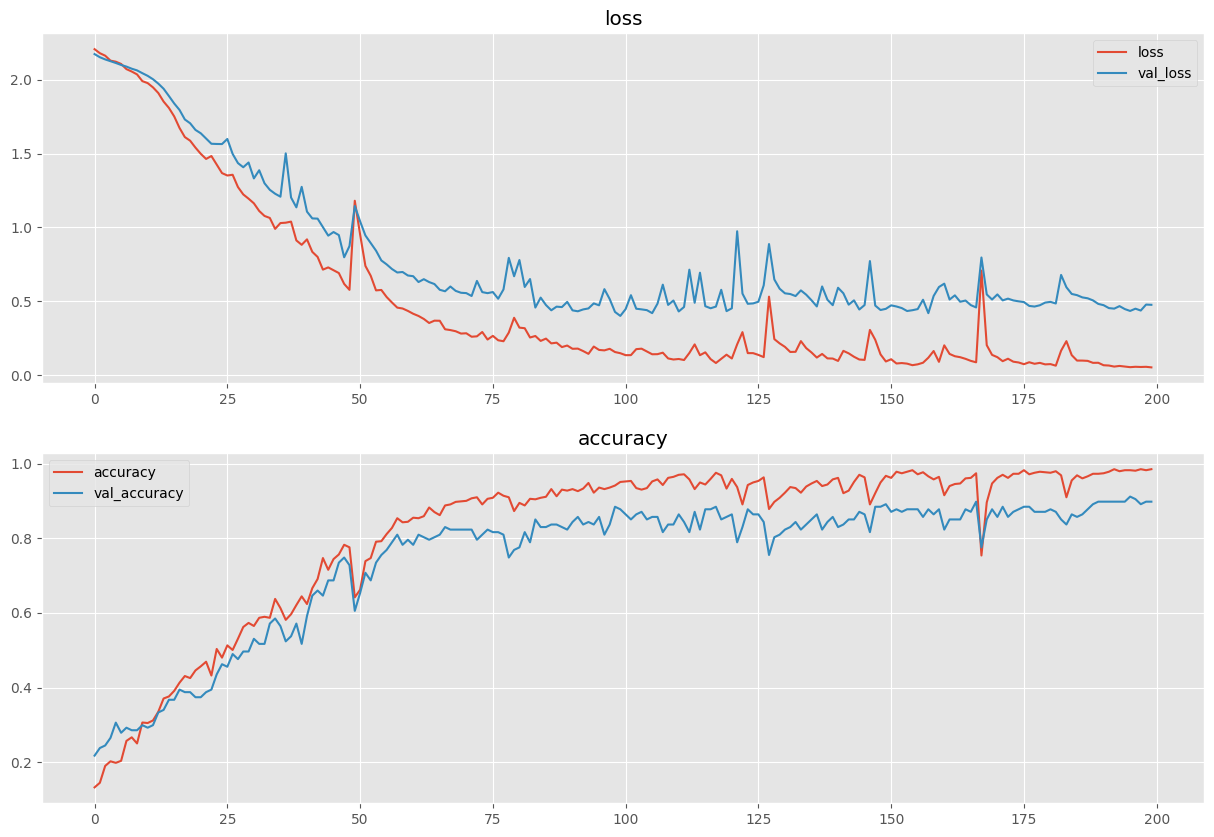

Validation Loss:  0.4763583242893219
Validation Accuracy: 89.80%
Test Loss:  0.5212982892990112
Test Accuracy: 86.36%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_1\assets


CV Iteration 2/6


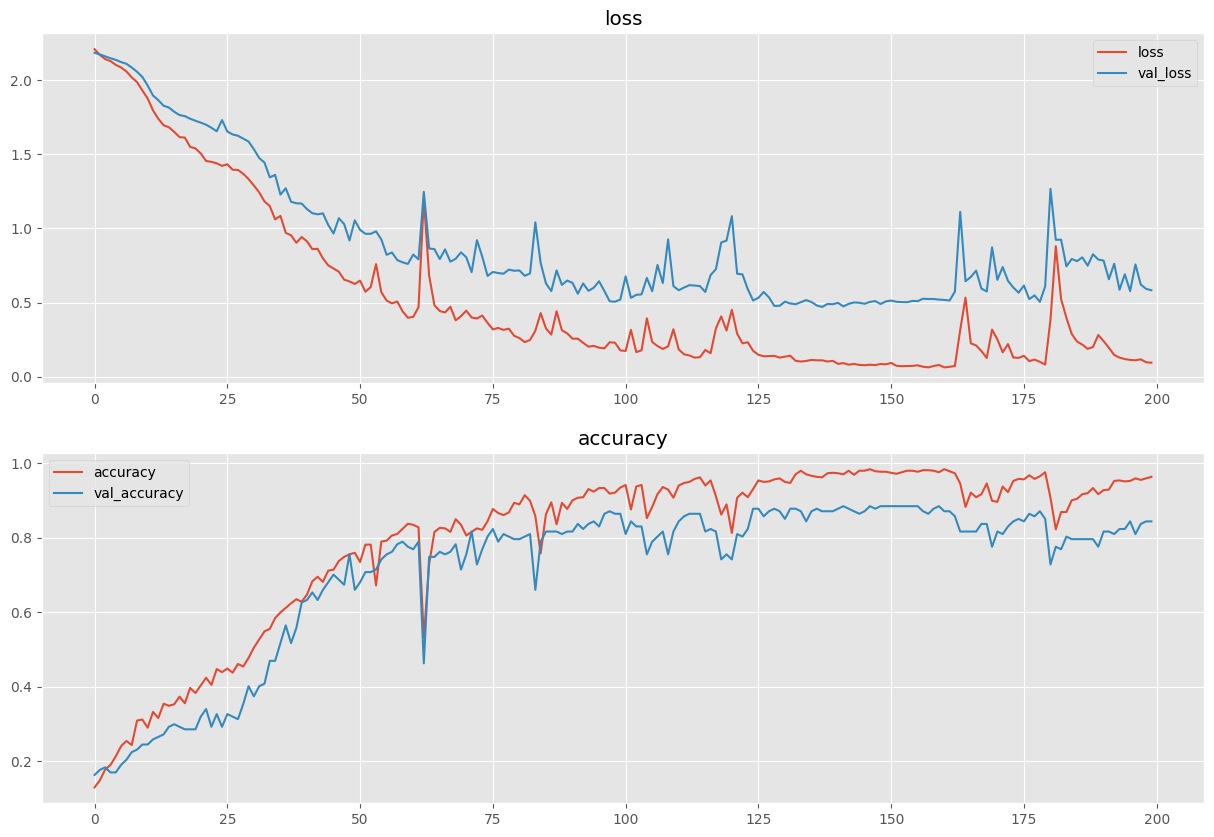

Validation Loss:  0.5837773680686951
Validation Accuracy: 84.35%
Test Loss:  0.59241783618927
Test Accuracy: 84.55%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_2\assets


CV Iteration 3/6


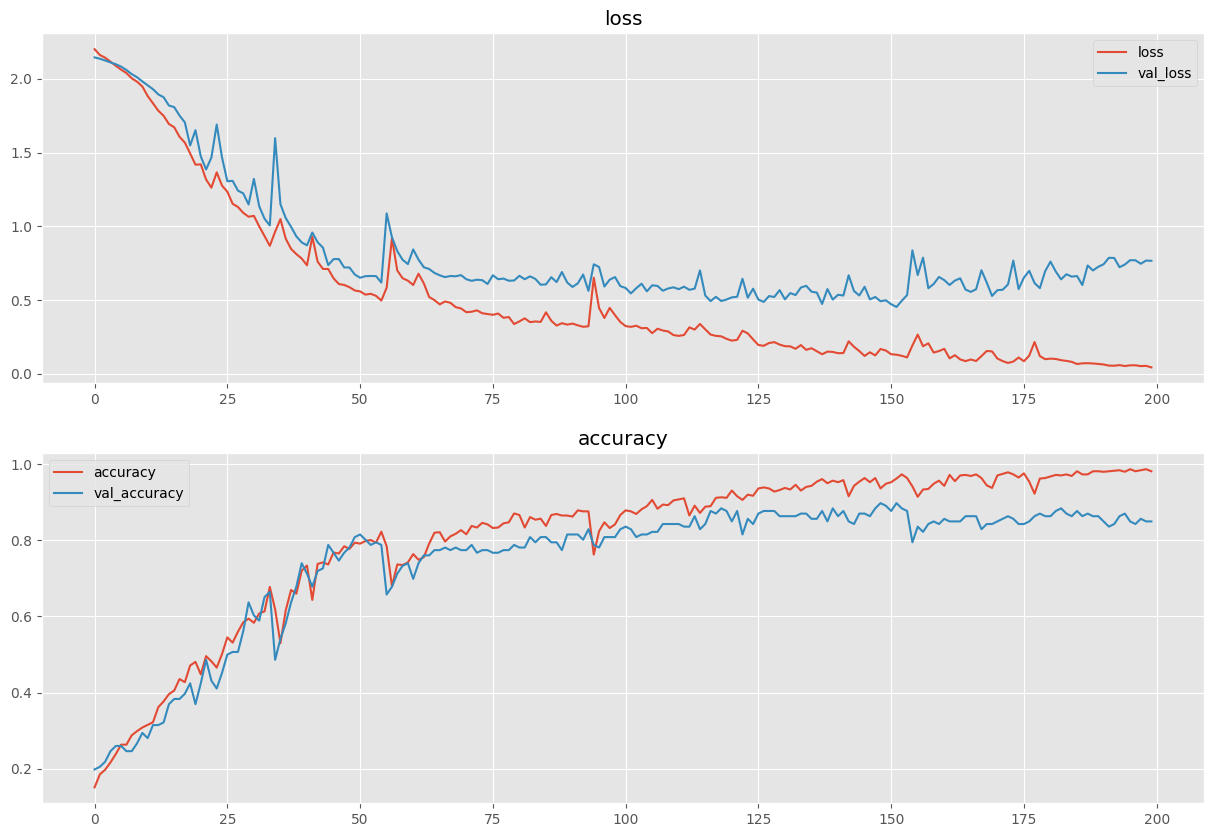

Validation Loss:  0.7660478949546814
Validation Accuracy: 84.93%
Test Loss:  0.6501463055610657
Test Accuracy: 85.91%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_3\assets


CV Iteration 4/6


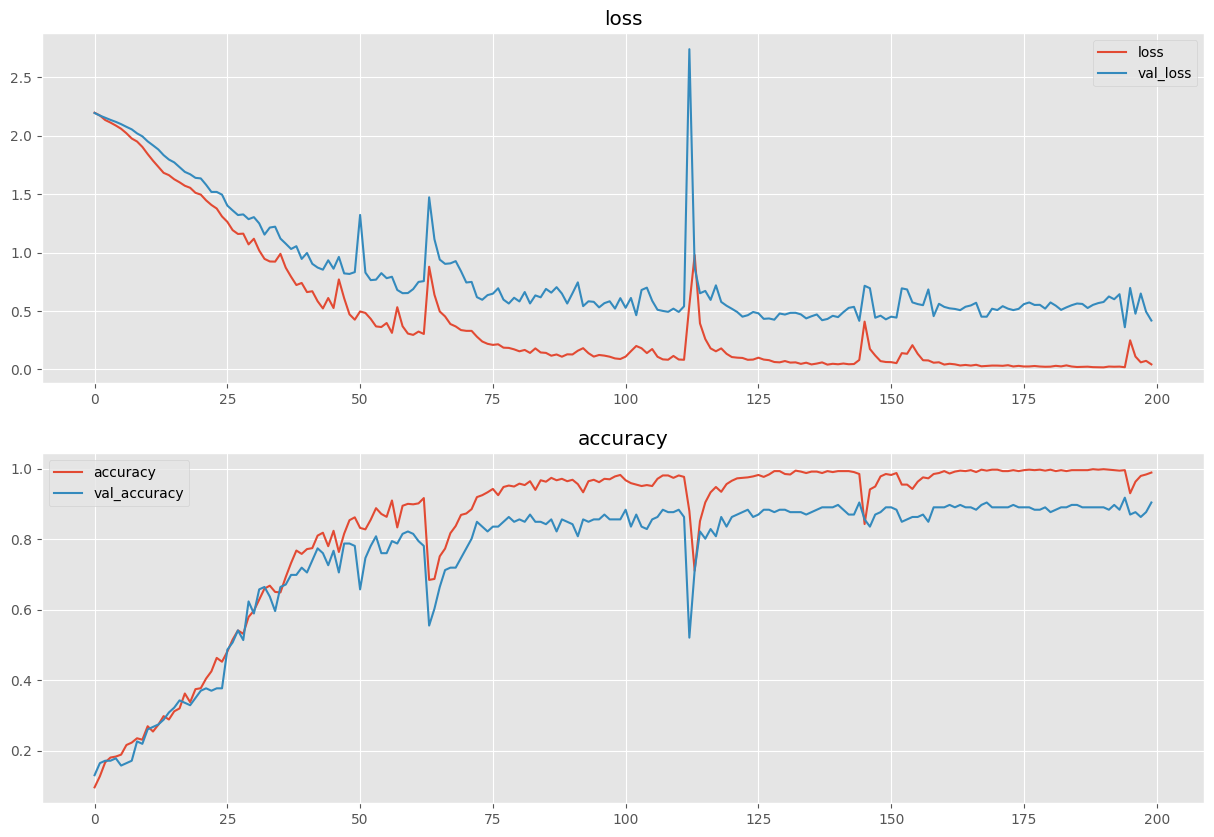

Validation Loss:  0.41801974177360535
Validation Accuracy: 90.41%
Test Loss:  0.36400163173675537
Test Accuracy: 92.27%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_4\assets


CV Iteration 5/6


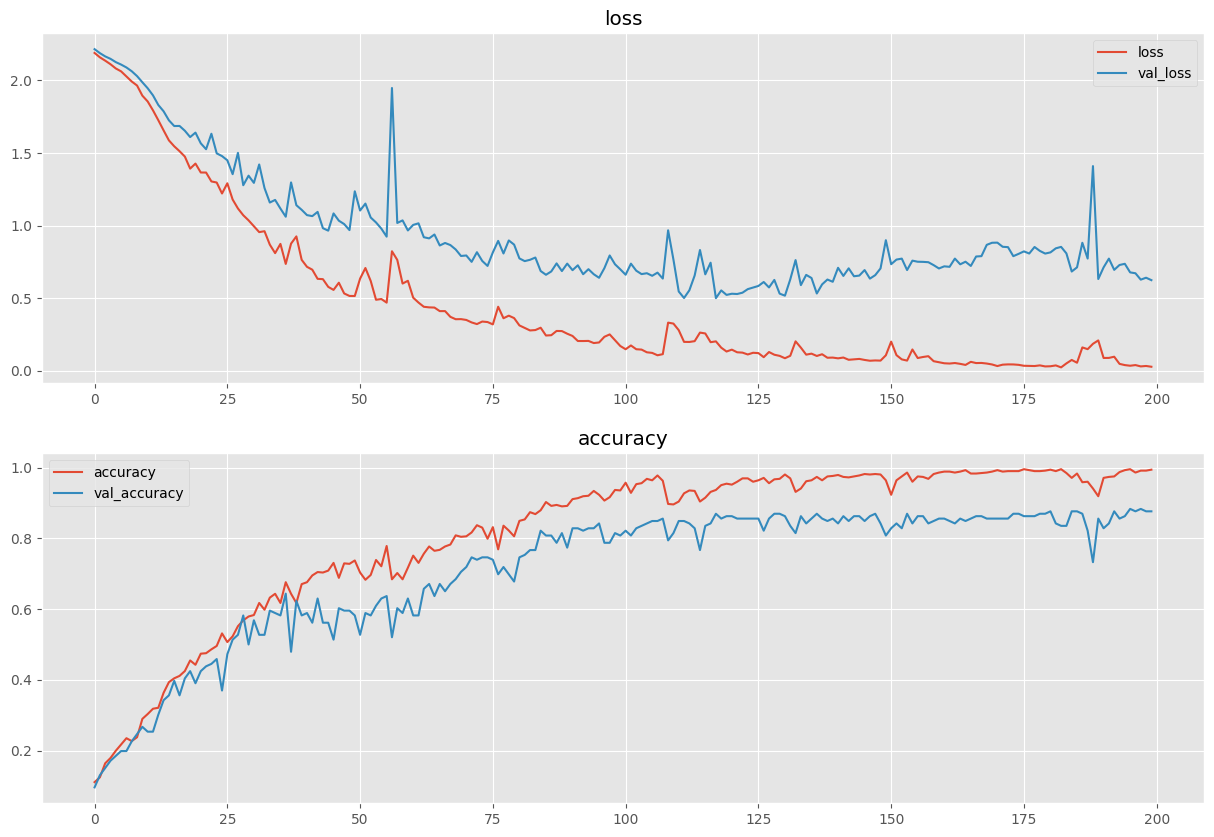

Validation Loss:  0.6246552467346191
Validation Accuracy: 87.67%
Test Loss:  0.38639527559280396
Test Accuracy: 91.36%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_5\assets


CV Iteration 6/6


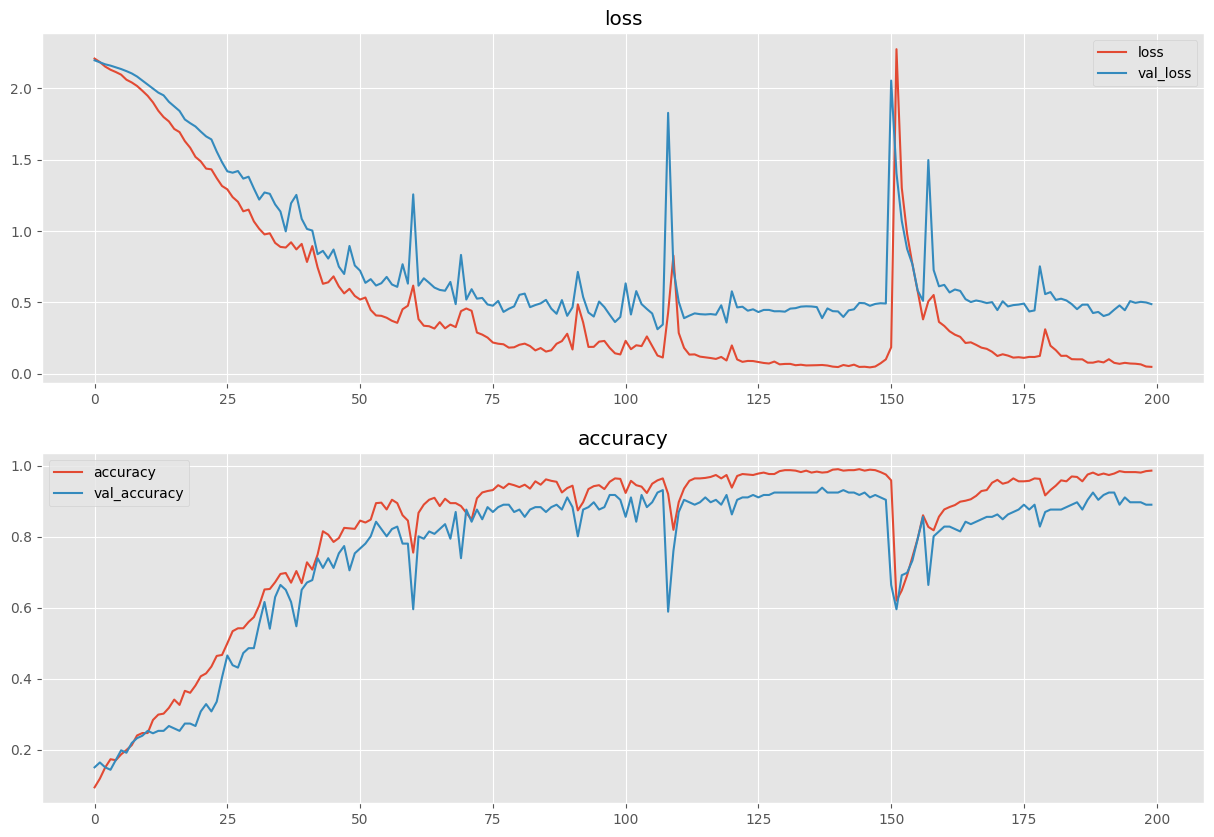

Validation Loss:  0.4886910021305084
Validation Accuracy: 89.04%
Test Loss:  0.4306809604167938
Test Accuracy: 90.91%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_6\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.5595915963252386
CV Mean Validation Accuracy: 87.70% sd: 2.32%
CV Mean Test Loss: 0.4908233831326167
CV Mean Test Accuracy: 88.56% sd: 3.03%


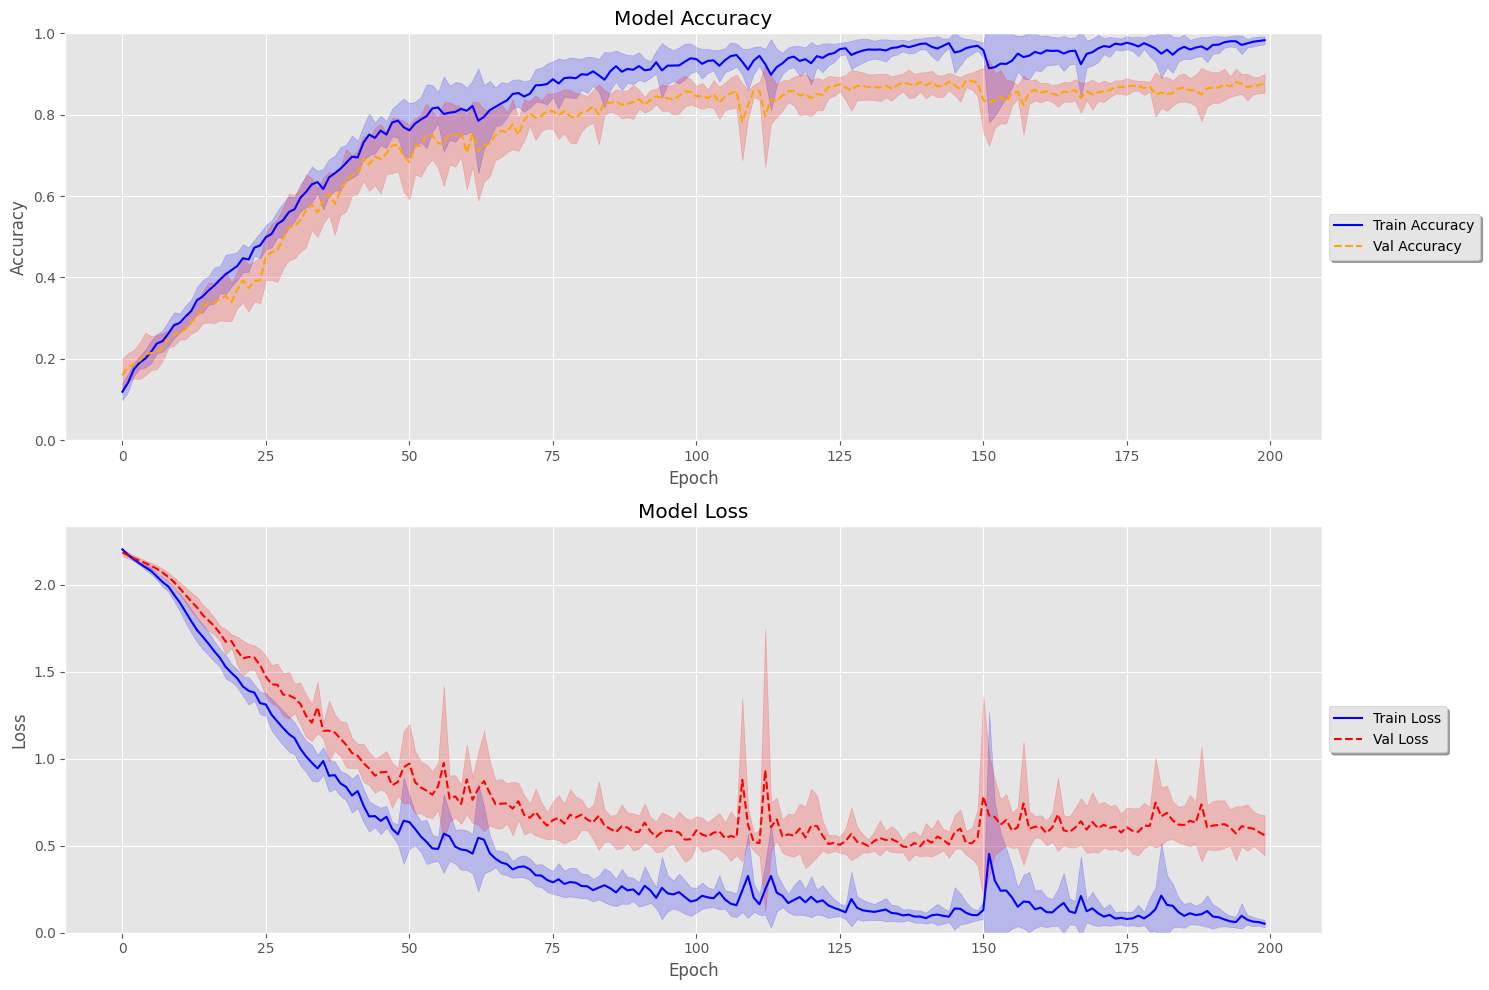

In [31]:
%matplotlib inline

def create_LSTM_model(model_input:tuple,model_output:int):

    model = tf.keras.models.Sequential(name='LSTM_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = model_input))

    # Hidden Layers (Stacked LSTMs)
    model.add(tf.keras.layers.LSTM(128, return_sequences=True, stateful=False))
    model.add(tf.keras.layers.LSTM(64, return_sequences=False, stateful=False))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    # Add 1 Dense Layer
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    # Output Layer
    model.add(tf.keras.layers.Dense(model_output, activation = 'softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])
    return model

def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

lstm_cv_histories = [] # Save the history of each iteration in cv
lstm_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
lstm_cv_val_loss = [] # Save the validation loss of each iteration in cv
lstm_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
lstm_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Convert X data to 3D numpy arrays (samples,timesteps, channels) and labels to 1D numpy arrays
    lstm_X_train, lstm_y_train = convert_X_data_to_3D_array(X_train_folds), np.array(y_train_folds)
    lstm_X_val, lstm_y_val = convert_X_data_to_3D_array(X_val_fold), np.array(y_val_fold)

    # Define input and outpout shape for the model
    input_size = (lstm_X_train.shape[1], lstm_X_train.shape[2])
    output_size = np.max(lstm_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_LSTM_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(lstm_X_train.shape))
        print(model.summary())
        tf.keras.utils.plot_model(model,to_file="Images\models\LSTM.png",show_layer_names=False,show_layer_activations=True,show_shapes=False,show_dtype=False,rankdir="TB",dpi=296)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lstm_y_train), y=lstm_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    lstm_history = model.fit(x = lstm_X_train, y = lstm_y_train,
                        validation_data=(lstm_X_val, lstm_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(lstm_history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    lstm_cv_histories.append(lstm_history.history)

    # Evaluate the model with the validation data for each CV Iteration
    lstm_val_scores = model.evaluate(lstm_X_val, lstm_y_val, verbose=0)
    print("Validation Loss: ",  (lstm_val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (lstm_val_scores[1]*100))
    lstm_cv_val_loss.append(lstm_val_scores[0])
    lstm_cv_val_accuracy.append(lstm_val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    lstm_X_test, lstm_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)
    lstm_test_scores = model.evaluate(lstm_X_test, lstm_y_test, verbose=0)
    print("Test Loss: ",  (lstm_test_scores[0]))
    print("Test Accuracy: %.2f%%" % (lstm_test_scores[1]*100))
    lstm_cv_test_loss.append(lstm_test_scores[0])
    lstm_cv_test_accuracy.append(lstm_test_scores[1]*100)

    lstm_path = "MY_DATA\Keras_Models\LSTM"
    model_filename = '\LSTM-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(lstm_path): os.makedirs(lstm_path)
    model.save(lstm_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(lstm_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(lstm_cv_val_accuracy), np.std(lstm_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(lstm_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(lstm_cv_test_accuracy), np.std(lstm_cv_test_accuracy)))
plot_mean_histories(lstm_cv_histories)


- LSTM Predictions

220/220 [==============================] - 4s 16ms/step

Correct predictions: 190/220


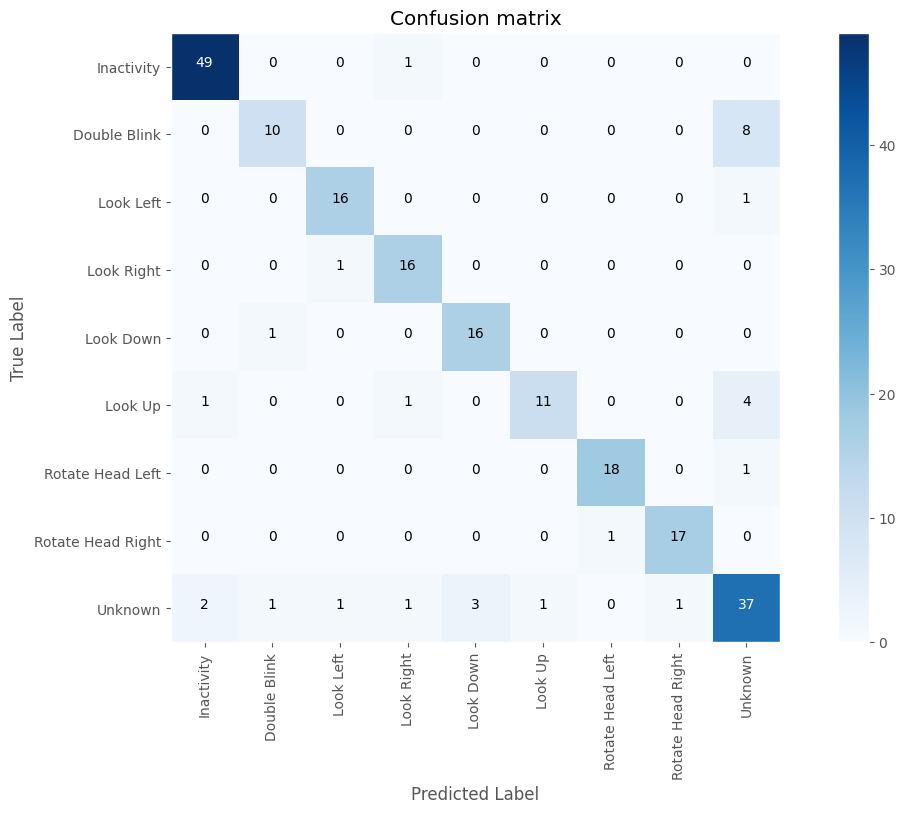

                   precision    recall  f1-score   support

       Inactivity       0.94      0.98      0.96        50
     Double Blink       0.83      0.56      0.67        18
        Look Left       0.89      0.94      0.91        17
       Look Right       0.84      0.94      0.89        17
        Look Down       0.84      0.94      0.89        17
          Look Up       0.92      0.65      0.76        17
 Rotate Head Left       0.95      0.95      0.95        19
Rotate Head Right       0.94      0.94      0.94        18
          Unknown       0.73      0.79      0.76        47

         accuracy                           0.86       220
        macro avg       0.88      0.85      0.86       220
     weighted avg       0.87      0.86      0.86       220

Predictions Threshold (80%) Pass:  185
Average prediction time for a sample in (ms): 67.44768186049029


In [32]:
loaded_lstm_model = tf.keras.models.load_model("MY_DATA\Keras_Models\LSTM\LSTM-CV_training_Iteration_1")

# Make predictions on the test data
lstm_predictions = np.argmax(loaded_lstm_model.predict(lstm_X_test, batch_size=1), axis=-1)
plot_Confusion_Matrix(lstm_y_test, lstm_predictions, LABEL_NAMES)
print(classification_report(lstm_y_test, lstm_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

lstm_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(lstm_X_test.shape[0]):
    move_to_predict = np.expand_dims(lstm_X_test[i], axis=0)
    start_time = time.time()
    lstm_sample_prediction = loaded_lstm_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(lstm_sample_prediction[0]) >= threshold and np.argmax(lstm_sample_prediction[0]) == lstm_y_test[i]): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    lstm_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(lstm_keep_inference_times))

## CNN Model

------------------------------------------------------------------------
Input Shape: (731, 192, 6)
Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 128)           15488     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                       

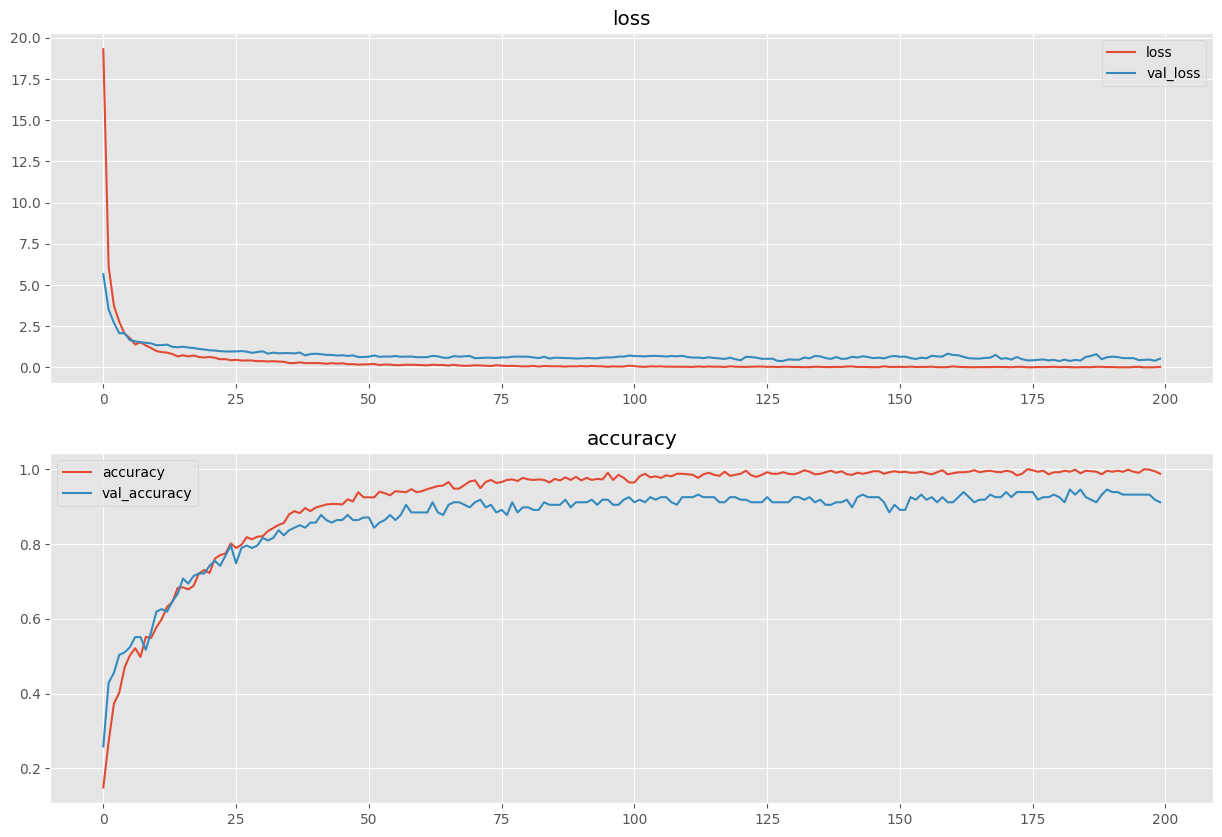

Validation Loss:  0.5308831930160522
Validation Accuracy: 91.16%
Test Loss:  0.4928421676158905
Test Accuracy: 93.18%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_1\assets


CV Iteration 2/6


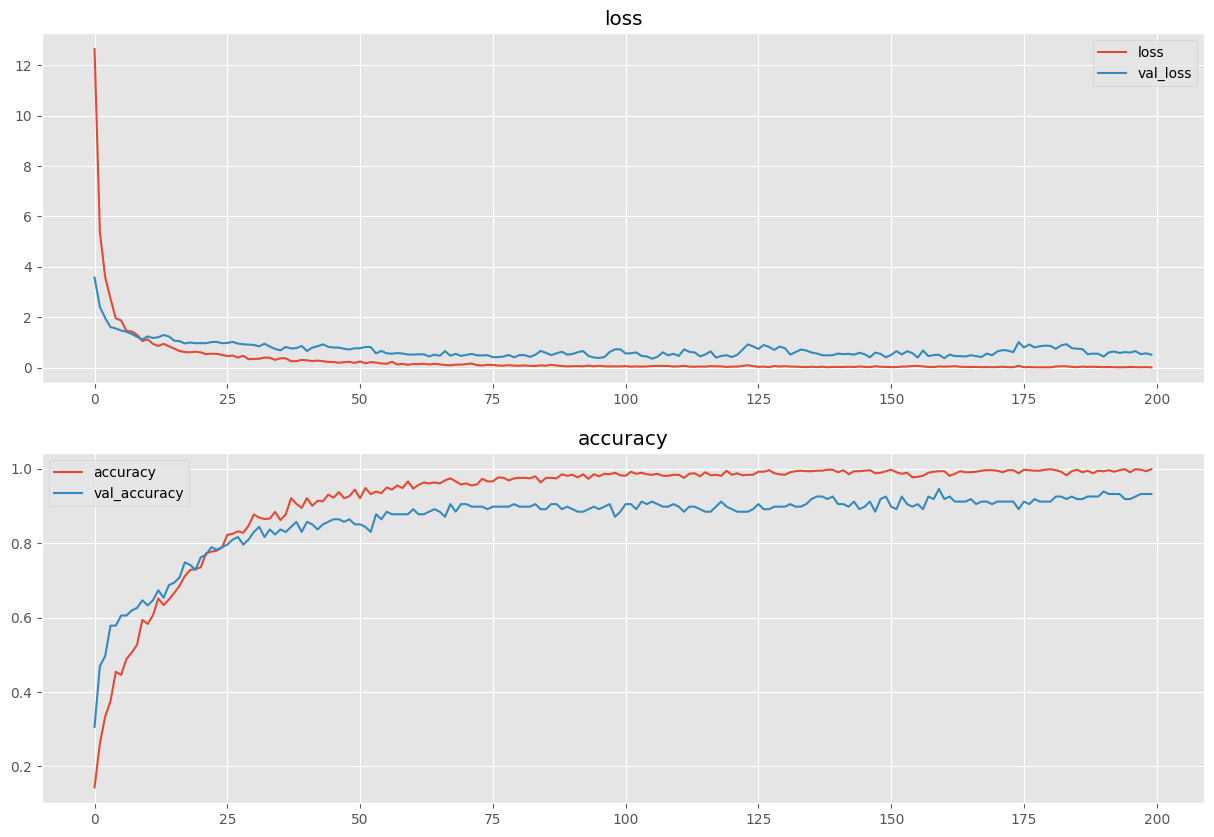

Validation Loss:  0.5104175806045532
Validation Accuracy: 93.20%
Test Loss:  0.5206835865974426
Test Accuracy: 95.00%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_2\assets


CV Iteration 3/6


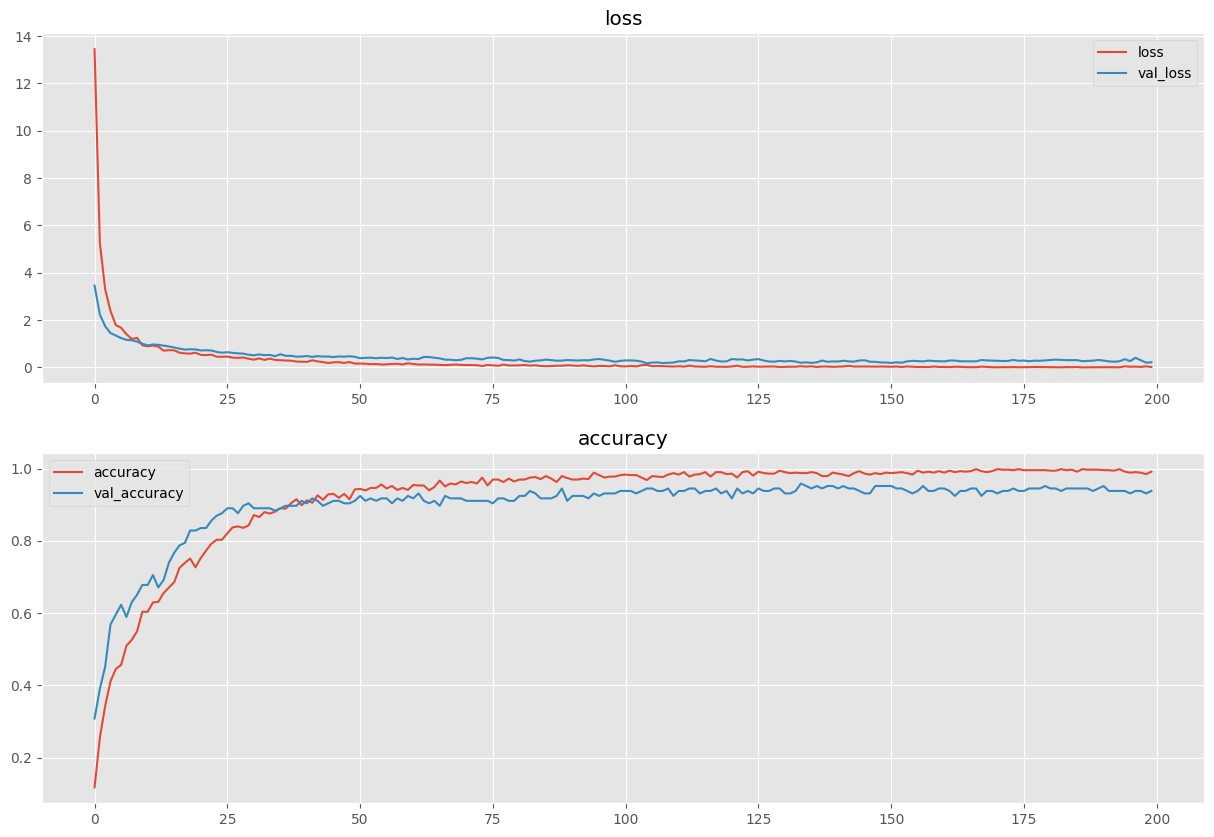

Validation Loss:  0.21937671303749084
Validation Accuracy: 93.84%
Test Loss:  0.4443010985851288
Test Accuracy: 94.09%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_3\assets


CV Iteration 4/6


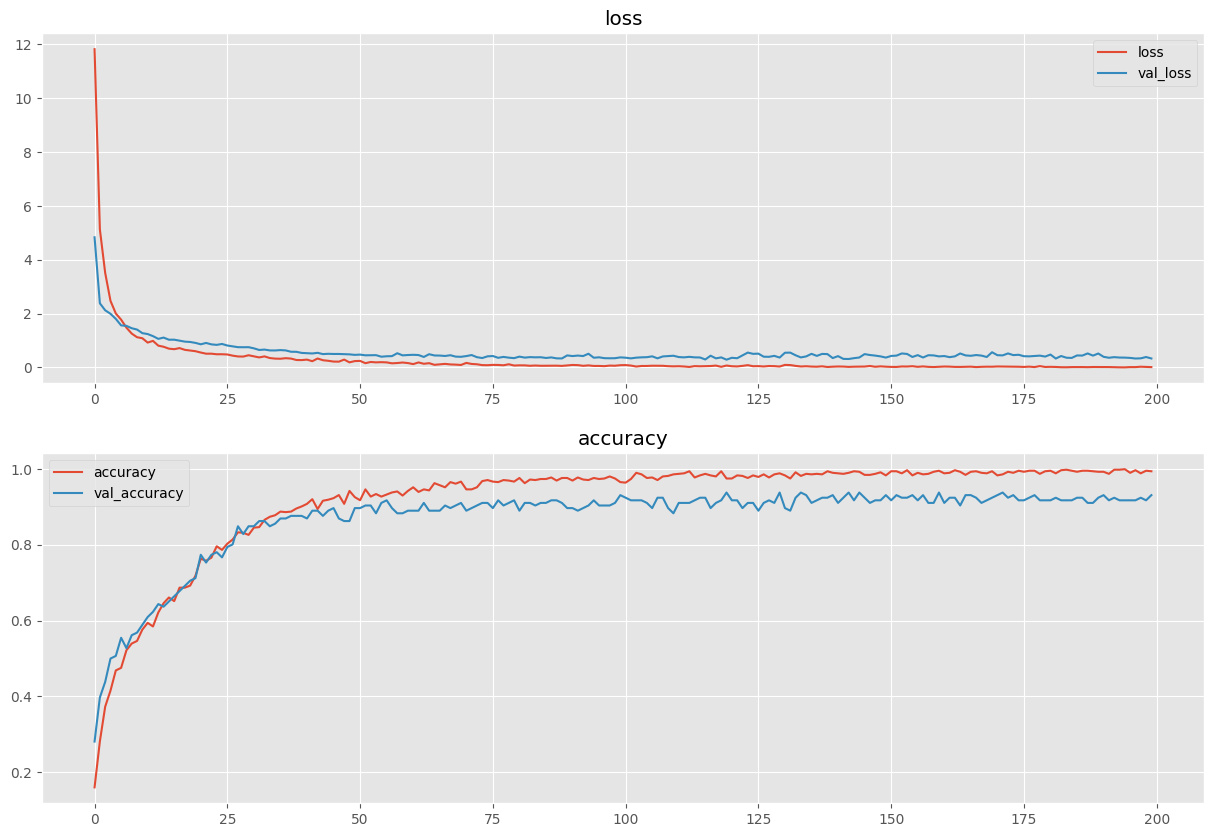

Validation Loss:  0.33507785201072693
Validation Accuracy: 93.15%
Test Loss:  0.44398775696754456
Test Accuracy: 95.00%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_4\assets


CV Iteration 5/6


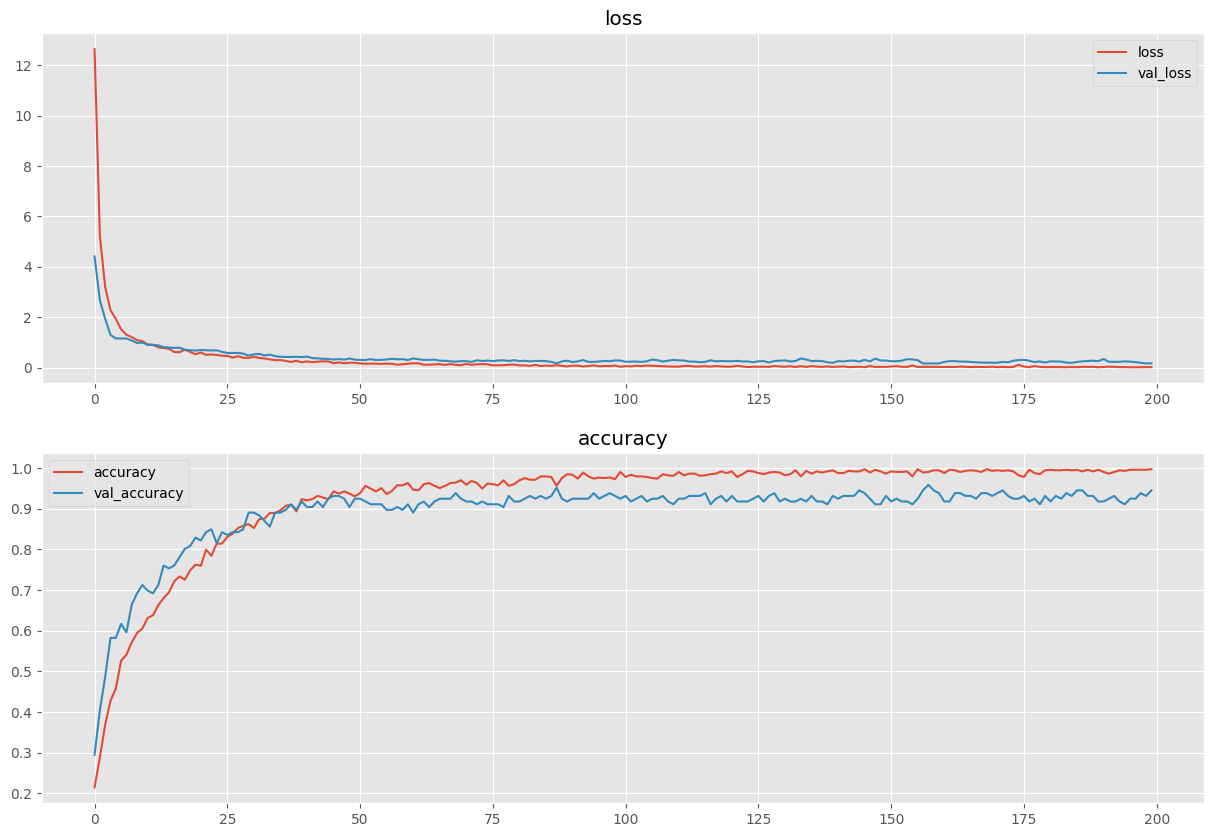

Validation Loss:  0.17051811516284943
Validation Accuracy: 94.52%
Test Loss:  0.3413527309894562
Test Accuracy: 95.00%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_5\assets


CV Iteration 6/6


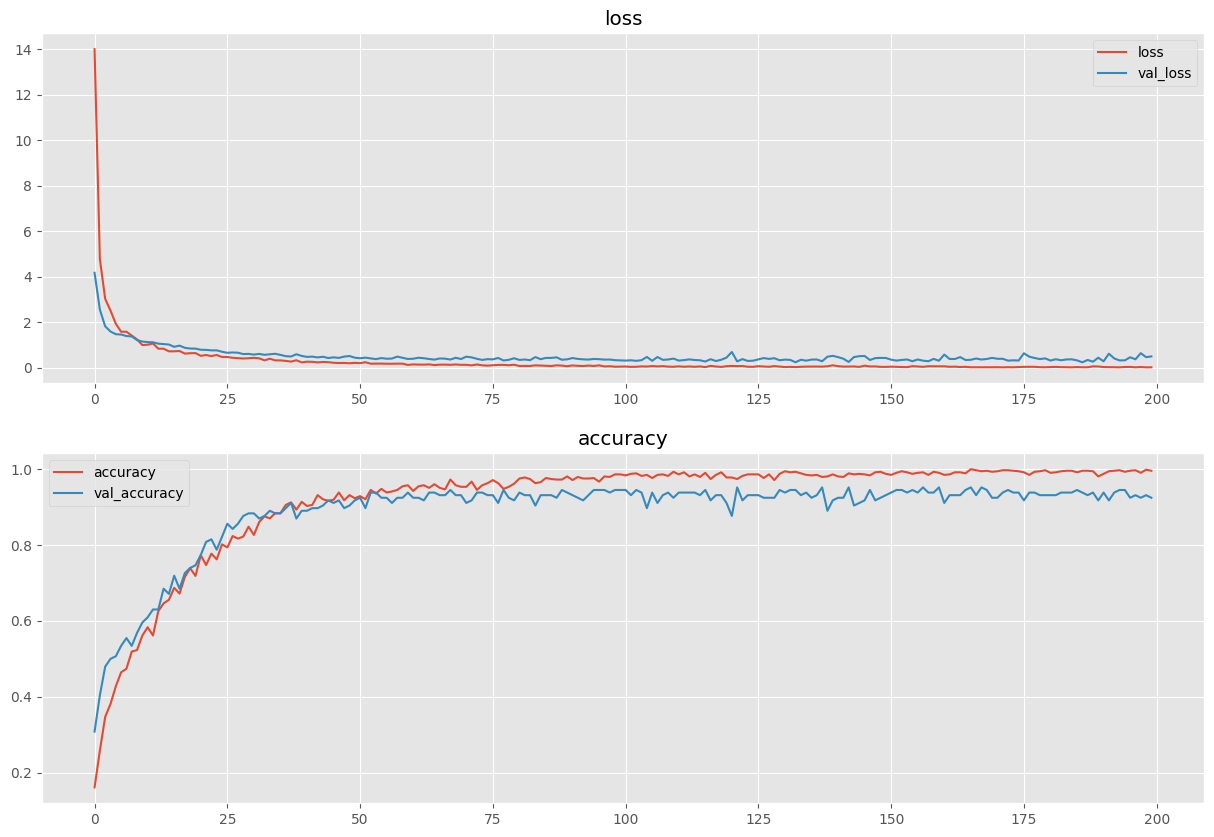

Validation Loss:  0.48995450139045715
Validation Accuracy: 92.47%
Test Loss:  0.481785386800766
Test Accuracy: 94.09%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_6\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.37603799253702164
CV Mean Validation Accuracy: 93.05% sd: 1.06%
CV Mean Test Loss: 0.4541587879260381
CV Mean Test Accuracy: 94.39% sd: 0.68%


In [34]:
def create_CNN_model(model_input:tuple,model_output:int):
    model = tf.keras.models.Sequential(name='CNN_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = model_input))

    # Add CNN and Pooling layers
    model.add(tf.keras.layers.Conv1D(filters = 128, kernel_size = 20, strides = 4, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size = 4, strides=2))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.Flatten())

    # add 1- dense layer
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))

    model.add(tf.keras.layers.Dense(model_output, activation = 'softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])
    return model

def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

cnn_cv_histories = [] # Save the history of each iteration in cv
cnn_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
cnn_cv_val_loss = [] # Save the validation loss of each iteration in cv
cnn_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
cnn_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Convert X data to 3D numpy arrays (samples,timesteps, channels) and labels to 1D numpy arrays
    cnn_X_train, cnn_y_train = convert_X_data_to_3D_array(X_train_folds), np.array(y_train_folds)
    cnn_X_val, cnn_y_val = convert_X_data_to_3D_array(X_val_fold), np.array(y_val_fold)

    # Define input and outpout shape for the model
    input_size = (cnn_X_train.shape[1], cnn_X_train.shape[2])
    output_size = np.max(cnn_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_CNN_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(cnn_X_train.shape))
        print(model.summary())
        tf.keras.utils.plot_model(model,to_file="Images\models\CNN.png",show_layer_names=False,show_layer_activations=True,show_shapes=False,show_dtype=False,rankdir="TB",dpi=296)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cnn_y_train), y=cnn_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    cnn_history = model.fit(x = cnn_X_train, y = cnn_y_train,
                        validation_data=(cnn_X_val, cnn_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(cnn_history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    cnn_cv_histories.append(cnn_history.history)

    # Evaluate the model with the validation data for each CV Iteration
    cnn_val_scores = model.evaluate(cnn_X_val, cnn_y_val, verbose=0)
    print("Validation Loss: ",  (cnn_val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (cnn_val_scores[1]*100))
    cnn_cv_val_loss.append(cnn_val_scores[0])
    cnn_cv_val_accuracy.append(cnn_val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    cnn_X_test, cnn_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)
    cnn_test_scores = model.evaluate(cnn_X_test, cnn_y_test, verbose=0)
    print("Test Loss: ",  (cnn_test_scores[0]))
    print("Test Accuracy: %.2f%%" % (cnn_test_scores[1]*100))
    cnn_cv_test_loss.append(cnn_test_scores[0])
    cnn_cv_test_accuracy.append(cnn_test_scores[1]*100)

    cnn_path = "MY_DATA\Keras_Models\CNN"
    model_filename = '\CNN-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(cnn_path): os.makedirs(cnn_path)
    model.save(cnn_path + model_filename)

%matplotlib qt
print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(cnn_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_cv_val_accuracy), np.std(cnn_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(cnn_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_cv_test_accuracy), np.std(cnn_cv_test_accuracy)))
plot_mean_histories(cnn_cv_histories)

- CNN Predictions

220/220 [==============================] - 4s 3ms/step

Correct predictions: 207/220


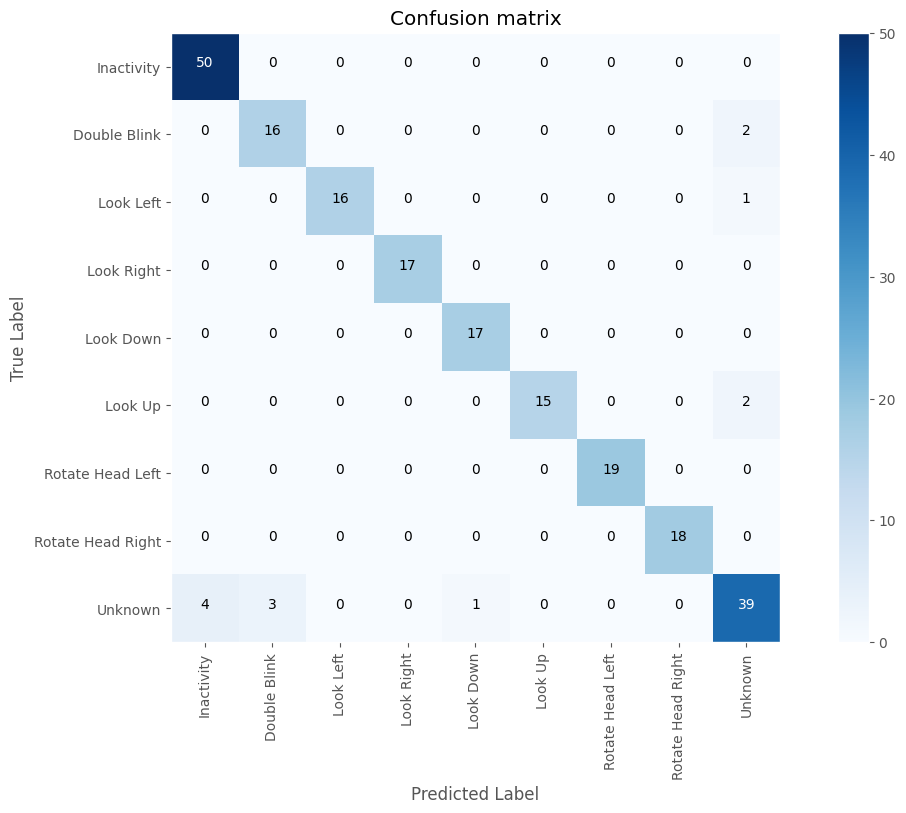

                   precision    recall  f1-score   support

       Inactivity       0.93      1.00      0.96        50
     Double Blink       0.84      0.89      0.86        18
        Look Left       1.00      0.94      0.97        17
       Look Right       1.00      1.00      1.00        17
        Look Down       0.94      1.00      0.97        17
          Look Up       1.00      0.88      0.94        17
 Rotate Head Left       1.00      1.00      1.00        19
Rotate Head Right       1.00      1.00      1.00        18
          Unknown       0.89      0.83      0.86        47

         accuracy                           0.94       220
        macro avg       0.96      0.95      0.95       220
     weighted avg       0.94      0.94      0.94       220

Predictions Threshold (80%) Pass:  204
Average prediction time for a sample in (ms): 46.0457444190979


In [5]:
def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

cnn_X_test, cnn_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)

loaded_cnn_model = tf.keras.models.load_model("MY_DATA\Keras_Models\CNN\CNN-CV_training_Iteration_3")

# Make predictions on the test data
cnn_predictions = np.argmax(loaded_cnn_model.predict(cnn_X_test, batch_size=1), axis=-1)
plot_Confusion_Matrix(cnn_y_test, cnn_predictions, LABEL_NAMES)
print(classification_report(cnn_y_test, cnn_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

cnn_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(cnn_X_test.shape[0]):
    move_to_predict = np.expand_dims(cnn_X_test[i], axis=0)
    start_time = time.time()
    cnn_sample_prediction = loaded_cnn_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(cnn_sample_prediction[0]) >= threshold and np.argmax(cnn_sample_prediction[0]) == cnn_y_test[i]): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    cnn_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(cnn_keep_inference_times))

## CNN-LSTM Model

------------------------------------------------------------------------
Input Shape: (731, 192, 6)
Model: "CNN-LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 96, 128)           15488     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 23, 64)            0         
                  

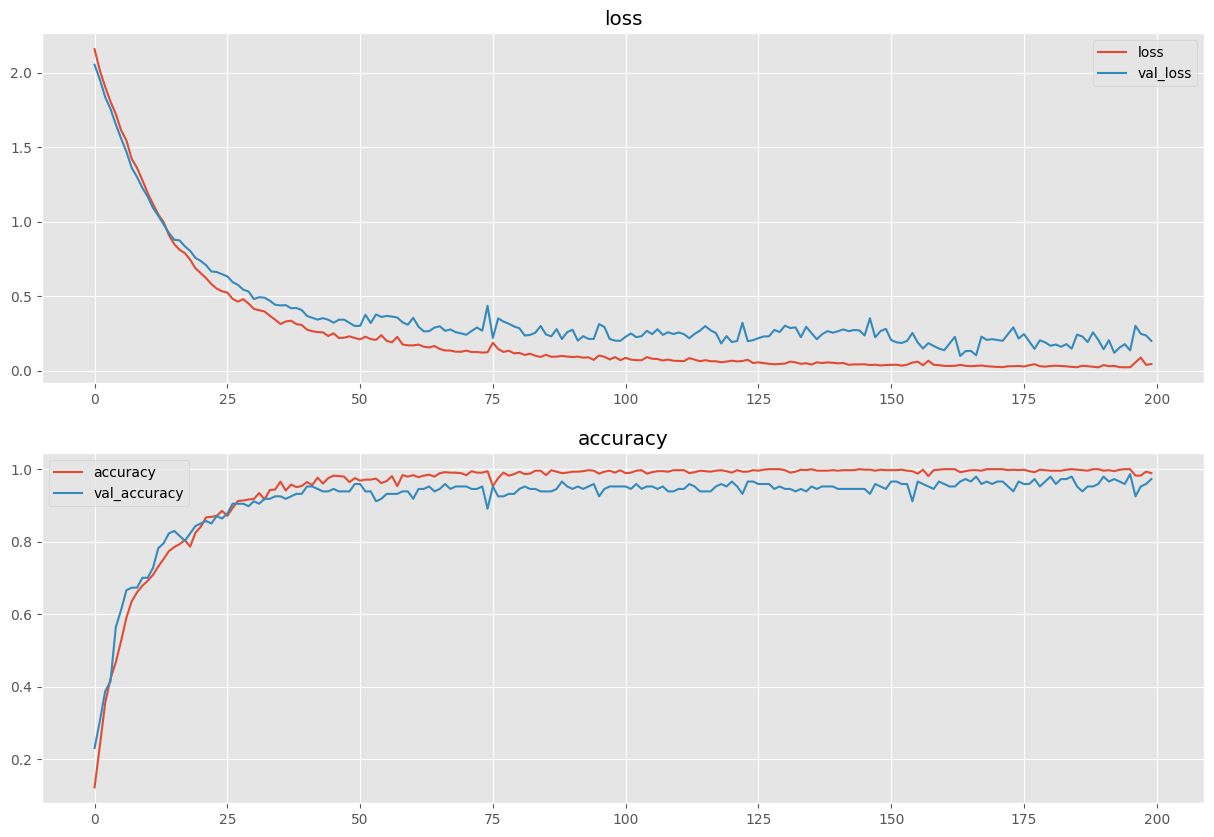

Validation Loss:  0.20091193914413452
Validation Accuracy: 97.28%
Test Loss:  0.1582327038049698
Test Accuracy: 95.91%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_1\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_1\assets


CV Iteration 2/6


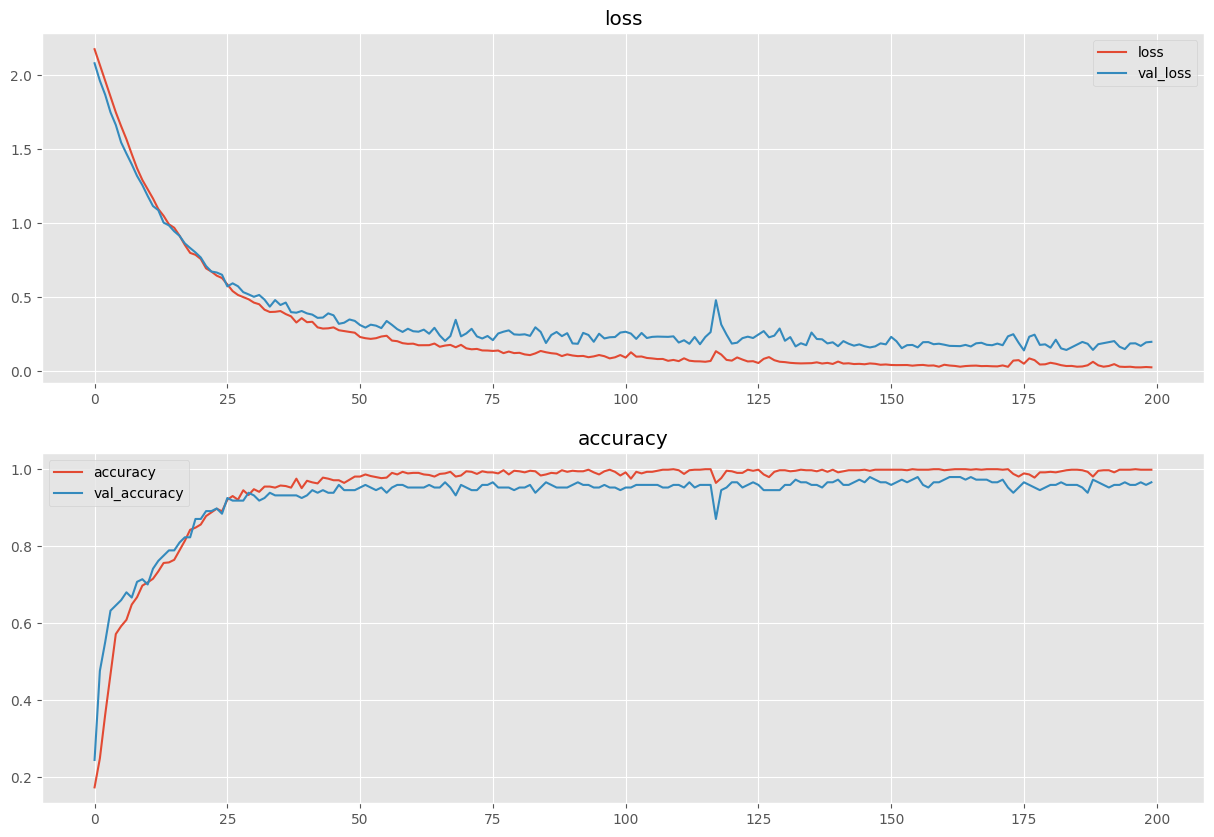

Validation Loss:  0.19720616936683655
Validation Accuracy: 96.60%
Test Loss:  0.16000810265541077
Test Accuracy: 96.82%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_2\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_2\assets


CV Iteration 3/6


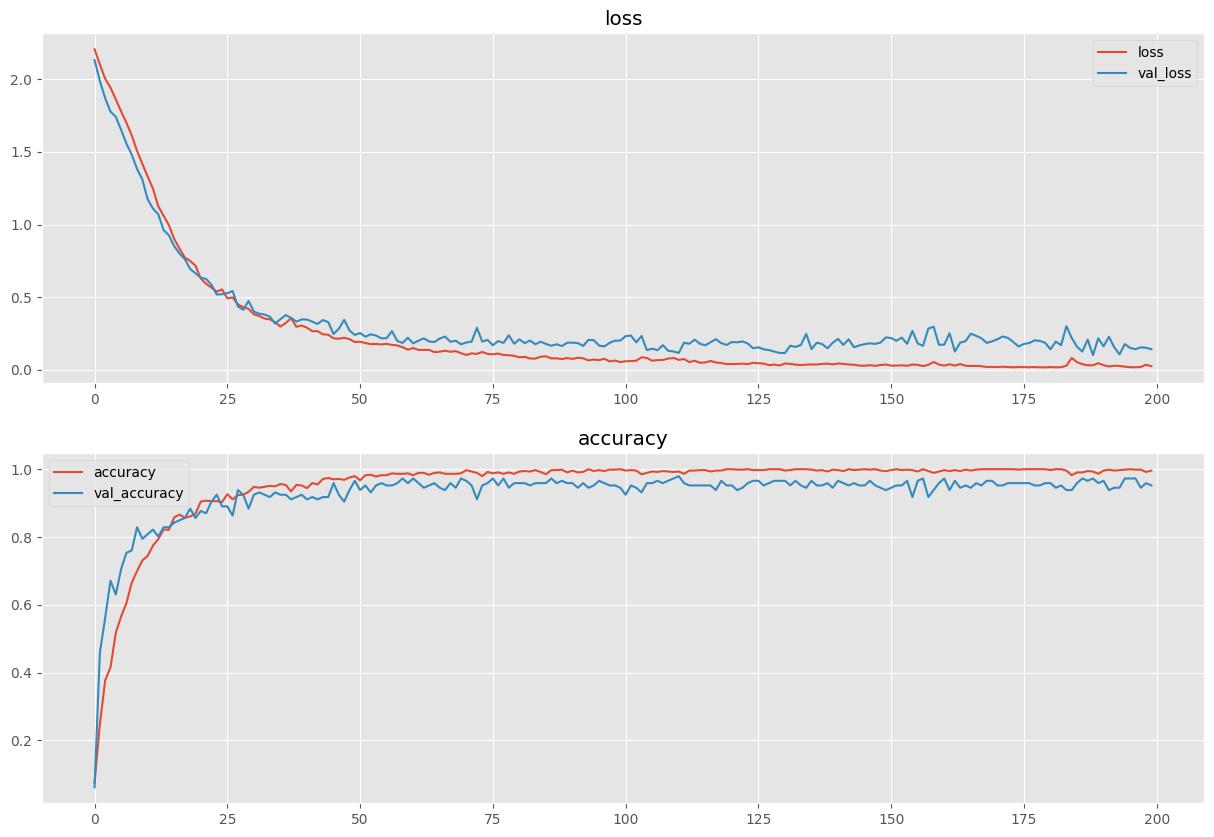

Validation Loss:  0.14254869520664215
Validation Accuracy: 95.21%
Test Loss:  0.1602364331483841
Test Accuracy: 97.27%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_3\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_3\assets


CV Iteration 4/6


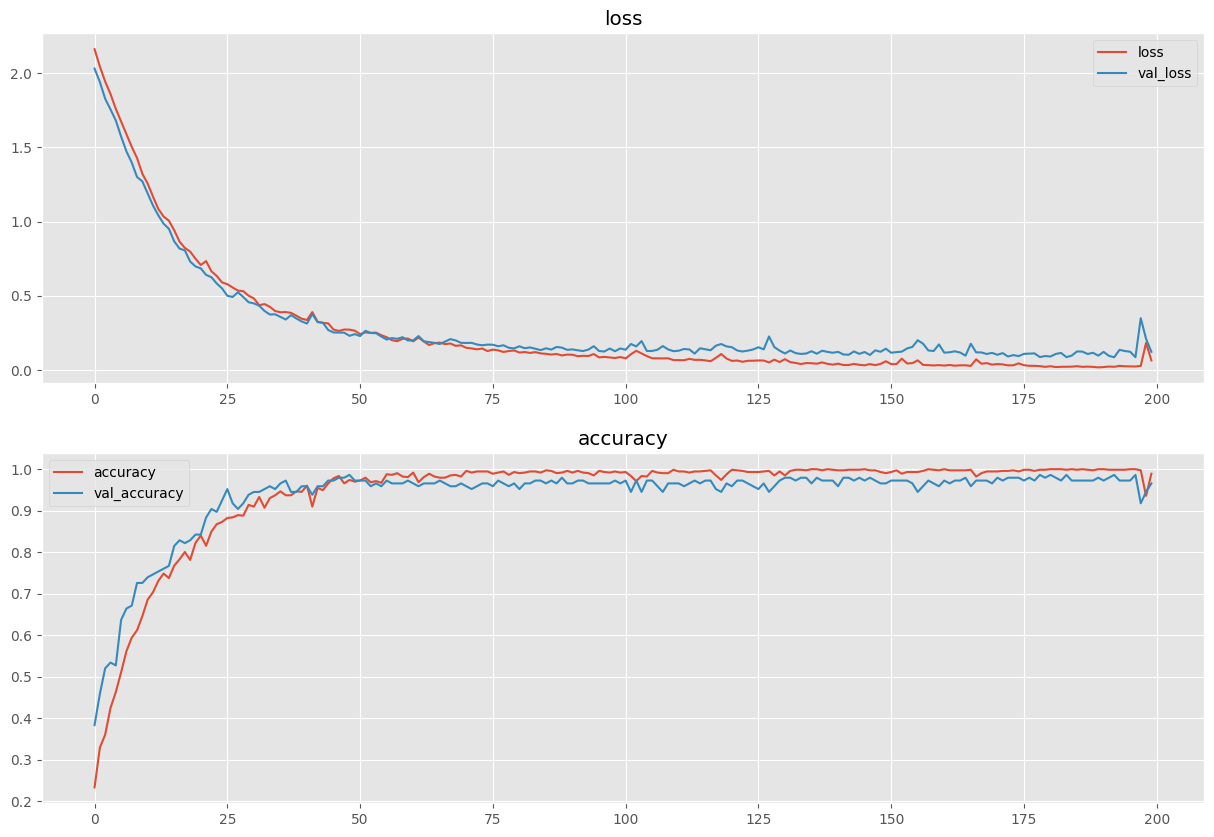

Validation Loss:  0.1224992573261261
Validation Accuracy: 96.58%
Test Loss:  0.24968691170215607
Test Accuracy: 93.18%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_4\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_4\assets


CV Iteration 5/6


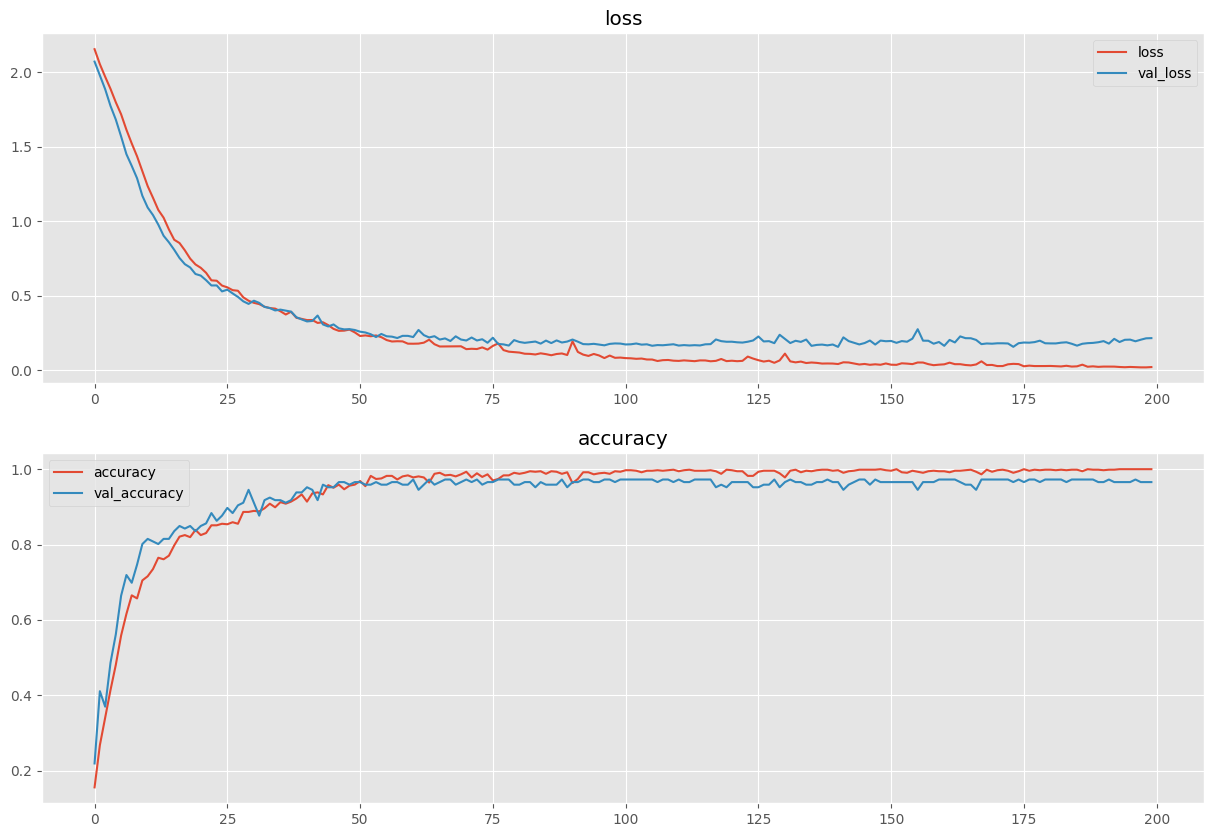

Validation Loss:  0.21420489251613617
Validation Accuracy: 96.58%
Test Loss:  0.07243653386831284
Test Accuracy: 97.73%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_5\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_5\assets


CV Iteration 6/6


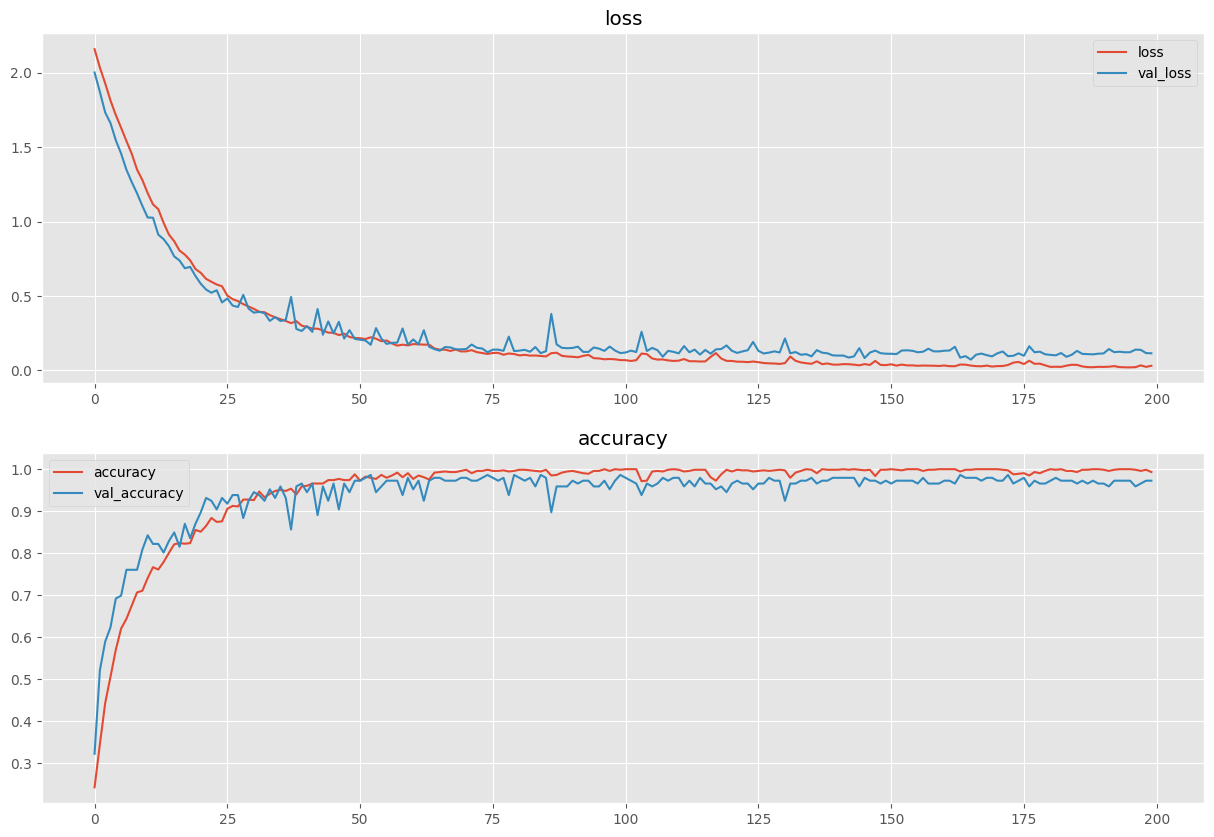

Validation Loss:  0.1155409887433052
Validation Accuracy: 97.26%
Test Loss:  0.12799669802188873
Test Accuracy: 96.82%


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_6\assets


INFO:tensorflow:Assets written to: MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_6\assets


------------------------------------------------------------------------
CV Mean Validation Loss: 0.1654853237171968
CV Mean Validation Accuracy: 96.58% sd: 0.69%
CV Mean Test Loss: 0.15476623053352037
CV Mean Test Accuracy: 96.29% sd: 1.49%


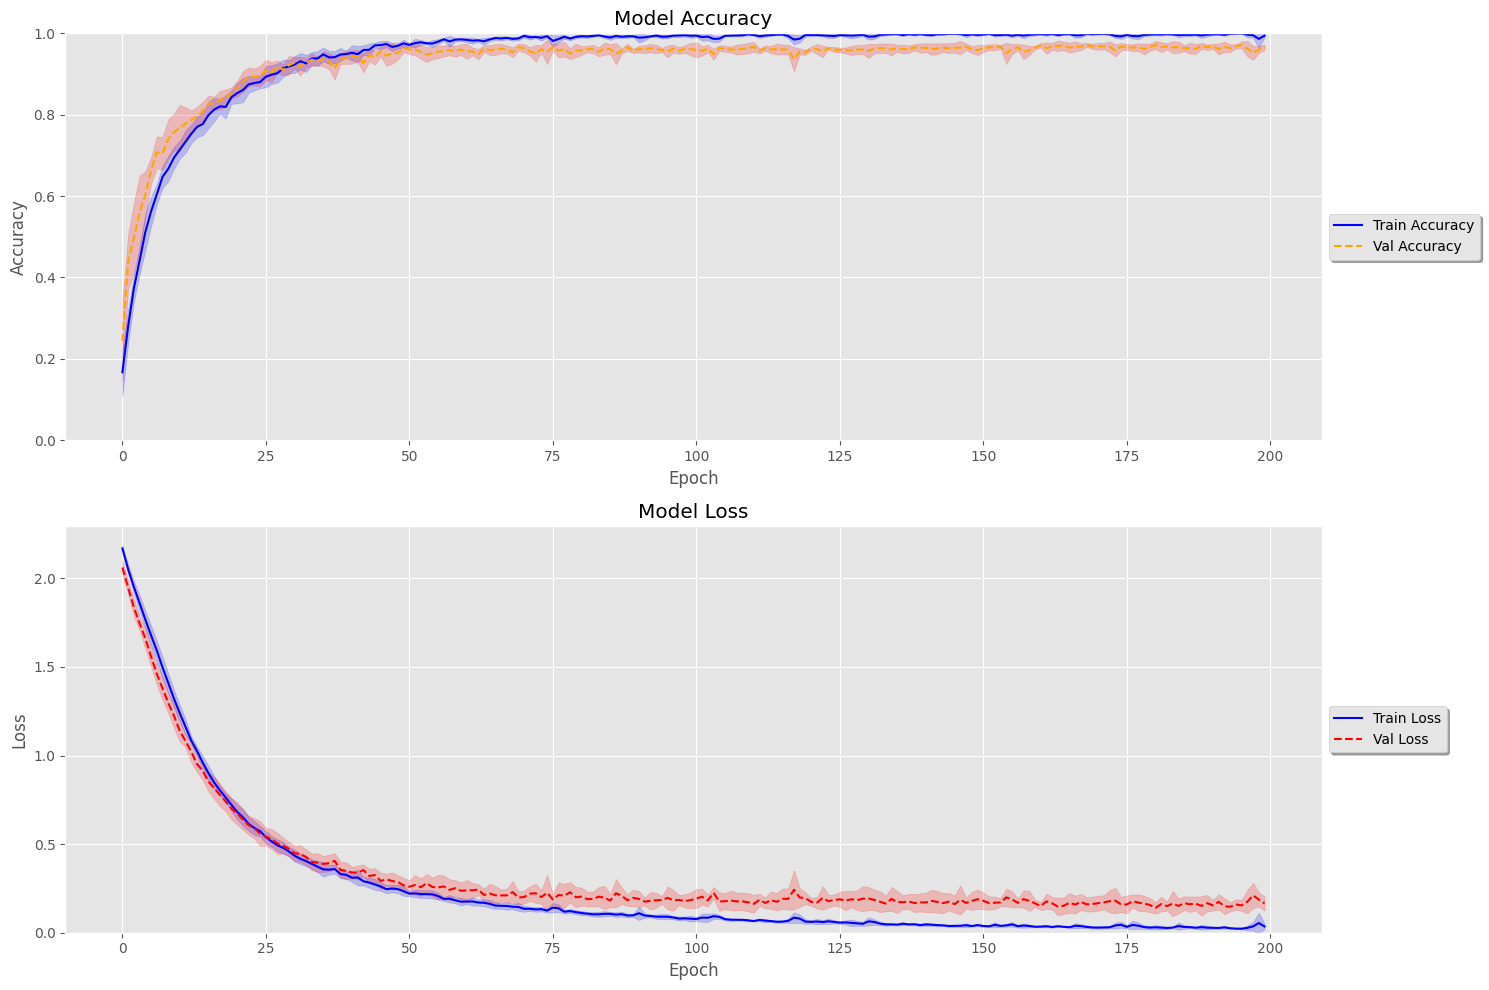

In [36]:
%matplotlib inline 
def create_CNN_LSTM_model(model_input:tuple,model_output:int):
    model = tf.keras.models.Sequential(name='CNN-LSTM_model') # Define model architecture
    # Input Layer
    model.add(tf.keras.layers.InputLayer(input_shape = model_input))

    # Add CNN and Pooling layers
    model.add(tf.keras.layers.Conv1D(filters = 128, kernel_size = 20, strides = 2, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 1, activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size = 4, strides=2))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))

    # Add LSTM layers
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, stateful = False))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))
    model.add(tf.keras.layers.LSTM(16, return_sequences = False, stateful = False))
    model.add(tf.keras.layers.Dropout(DROPOUT_SIZE))

    model.add(tf.keras.layers.Dense(model_output, activation = 'softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                metrics=["accuracy"])
    return model

def convert_X_data_to_3D_array(df_list):
    num_samples = len(df_list)
    timesteps, channels = df_list[0].shape
    result_array = np.zeros((num_samples, timesteps, channels))
    for i, df in enumerate(df_list): result_array[i] = df.to_numpy()
    return result_array

cnn_lstm_cv_histories = [] # Save the history of each iteration in cv
cnn_lstm_cv_val_accuracy = [] # Save the validation accuracy of each iteration in cv
cnn_lstm_cv_val_loss = [] # Save the validation loss of each iteration in cv
cnn_lstm_cv_test_accuracy = [] # Save the test accuracy of each iteration in cv
cnn_lstm_cv_test_loss = [] # Save the test loss of each iteration in cv

for i, ((X_train_folds, y_train_folds), (X_val_fold, y_val_fold)) in enumerate(cv_train_val_data):
    tf.keras.backend.clear_session() # Reset the session

    # Convert X data to 3D numpy arrays (samples,timesteps, channels) and labels to 1D numpy arrays
    cnn_lstm_X_train, cnn_lstm_y_train = convert_X_data_to_3D_array(X_train_folds), np.array(y_train_folds)
    cnn_lstm_X_val, cnn_lstm_y_val = convert_X_data_to_3D_array(X_val_fold), np.array(y_val_fold)

    # Define input and outpout shape for the model
    input_size = (cnn_lstm_X_train.shape[1], cnn_lstm_X_train.shape[2])
    output_size = np.max(cnn_lstm_y_val) + 1 # Number of categories:9

    # Create & compile model
    model = create_CNN_LSTM_model(model_input = input_size, model_output = output_size)

    if i == 0: # Plot the model
        print('------------------------------------------------------------------------')
        print("Input Shape: " + str(cnn_lstm_X_train.shape))
        print(model.summary())
        tf.keras.utils.plot_model(model,to_file="Images\models\CNN-LSTM.png",show_layer_names=False,show_layer_activations=True,show_shapes=False,show_dtype=False,rankdir="TB",dpi=296)
        print('------------------------------------------------------------------------')
    print(f"CV Iteration {i+1}/{len(cv_train_val_data)}")

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cnn_lstm_y_train), y=cnn_lstm_y_train)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Fit the model
    cnn_lstm_history = model.fit(x = cnn_lstm_X_train, y = cnn_lstm_y_train,
                        validation_data=(cnn_lstm_X_val, cnn_lstm_y_val),
                        epochs = EPOCHS, batch_size = BATCH_SIZE,
                        class_weight = class_weights_dict,
                        shuffle = True, verbose = 0)

    plot_history_metrics(cnn_lstm_history, val_split = True, metrics_to_plot=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    cnn_lstm_cv_histories.append(cnn_lstm_history.history)

    # Evaluate the model with the validation data for each CV Iteration
    cnn_lstm_val_scores = model.evaluate(cnn_lstm_X_val, cnn_lstm_y_val, verbose=0)
    print("Validation Loss: ",  (cnn_lstm_val_scores[0]))
    print("Validation Accuracy: %.2f%%" % (cnn_lstm_val_scores[1]*100))
    cnn_lstm_cv_val_loss.append(cnn_lstm_val_scores[0])
    cnn_lstm_cv_val_accuracy.append(cnn_lstm_val_scores[1]*100)

    # Evaluate the model with the test data for each CV Iteration
    cnn_lstm_X_test, cnn_lstm_y_test = convert_X_data_to_3D_array(X_test), np.array(y_test)
    cnn_lstm_test_scores = model.evaluate(cnn_lstm_X_test, cnn_lstm_y_test, verbose=0)
    print("Test Loss: ",  (cnn_lstm_test_scores[0]))
    print("Test Accuracy: %.2f%%" % (cnn_lstm_test_scores[1]*100))
    cnn_lstm_cv_test_loss.append(cnn_lstm_test_scores[0])
    cnn_lstm_cv_test_accuracy.append(cnn_lstm_test_scores[1]*100)

    cnn_lstm_path = "MY_DATA\Keras_Models\CNN_LSTM"
    model_filename = '\CNN_LSTM-CV_training_Iteration_' + str(i+1)
    if not os.path.exists(cnn_lstm_path): os.makedirs(cnn_lstm_path)
    model.save(cnn_lstm_path + model_filename)


print('------------------------------------------------------------------------')
print("CV Mean Validation Loss: " +  str(np.mean(cnn_lstm_cv_val_loss)))
print("CV Mean Validation Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_lstm_cv_val_accuracy), np.std(cnn_lstm_cv_val_accuracy)))
print("CV Mean Test Loss: " +  str(np.mean(cnn_lstm_cv_test_loss)))
print("CV Mean Test Accuracy: %.2f%% sd: %.2f%%" % (np.mean(cnn_lstm_cv_test_accuracy), np.std(cnn_lstm_cv_test_accuracy)))
plot_mean_histories(cnn_lstm_cv_histories)

- CNN-LSTM Predictions

220/220 [==============================] - 2s 5ms/step

Correct predictions: 213/220


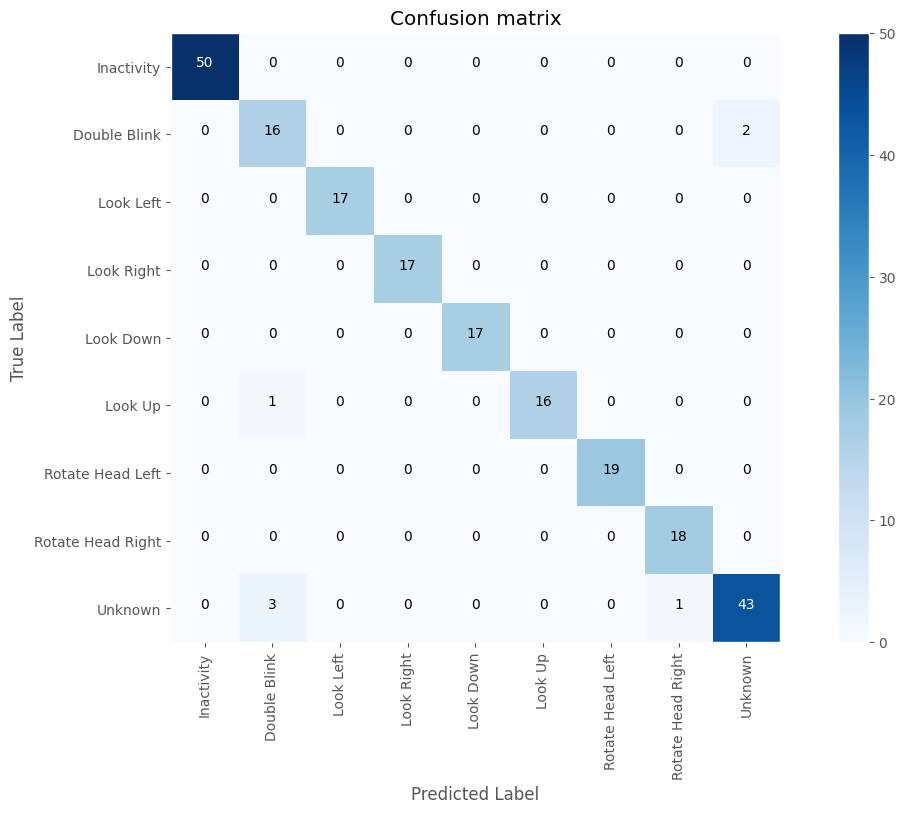

                   precision    recall  f1-score   support

       Inactivity       1.00      1.00      1.00        50
     Double Blink       0.80      0.89      0.84        18
        Look Left       1.00      1.00      1.00        17
       Look Right       1.00      1.00      1.00        17
        Look Down       1.00      1.00      1.00        17
          Look Up       1.00      0.94      0.97        17
 Rotate Head Left       1.00      1.00      1.00        19
Rotate Head Right       0.95      1.00      0.97        18
          Unknown       0.96      0.91      0.93        47

         accuracy                           0.97       220
        macro avg       0.97      0.97      0.97       220
     weighted avg       0.97      0.97      0.97       220

Predictions Threshold (80%) Pass:  211
Average prediction time for a sample in (ms): 48.312296650626436


In [37]:
loaded_cnn_lstm_model = tf.keras.models.load_model("MY_DATA\Keras_Models\CNN_LSTM\CNN_LSTM-CV_training_Iteration_2")

# Make predictions on the test data
cnn_lstm_predictions = np.argmax(loaded_cnn_lstm_model.predict(cnn_lstm_X_test, batch_size=1), axis=-1)
plot_Confusion_Matrix(cnn_lstm_y_test, cnn_lstm_predictions, LABEL_NAMES)
print(classification_report(cnn_lstm_y_test, cnn_lstm_predictions, target_names=LABEL_NAMES))

# Also lets check the inference time for predictions and threshold.

cnn_lstm_keep_inference_times = []
threshold = 0.8
threshold_counter = 0

for i in range(cnn_lstm_X_test.shape[0]):
    move_to_predict = np.expand_dims(cnn_lstm_X_test[i], axis=0)
    start_time = time.time()
    cnn_lstm_sample_prediction = loaded_cnn_lstm_model.predict(move_to_predict, batch_size=1,verbose=0)
    end_time = time.time()
    if (max(cnn_lstm_sample_prediction[0]) >= threshold and np.argmax(cnn_lstm_sample_prediction[0]) == cnn_lstm_y_test[i]): # Here the [0] is cause we have a nested list as return, but we only check one sample per time
        threshold_counter += 1
    cnn_lstm_keep_inference_times.append(end_time - start_time)

print('Predictions Threshold (80%) Pass: ',threshold_counter)
print("Average prediction time for a sample in (ms):", 1000*np.mean(cnn_lstm_keep_inference_times))